In [1]:
!rm -rf img/ && mkdir -p img

In [2]:
import time

import figtools as ftl
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim

In [3]:
from helper.data import DataLoader, init_state
from helper.ukf import init_ukf

In [4]:
torch.manual_seed(0)
assert torch.all(torch.randint(10, (10,)) == torch.tensor([4, 9, 3, 0, 3, 9, 7, 3, 7, 3]))

In [5]:
data_loader = DataLoader(phi=torch.tensor([0., np.pi / 2., np.pi, 3. / 2. * np.pi]),
                         v0=torch.tensor([1., 2., 3., 4.]),
                         n=30,
                         n_repeat=7)
X, _ = data_loader(window_size=100, randomize=True)
X.shape

torch.Size([4, 2, 111, 100])

In [6]:
def train_window(X, *, f, optimizer, state_cov):
    b, _, _ = X.shape
    
    optimizer.zero_grad()

    Y, state, state_covs = f(X, init_state(X), state_cov)
    loss = torch.sum((X - Y)**2, dim=(1, 2))
    loss.backward(torch.ones(b))

    optimizer.step()

    return {
        'process_noise': f.process_noise.detach(),
        'measurement_noise': f.measurement_noise.detach(),
        'state_cov': state_covs[:, :, :, -1].detach(),
        'loss': loss.tolist(),
    }


def train_epoch(X, *, f, optimizer, w_max=None):
    b, _, w, _ = X.shape
    if w_max:
        w = min(w, w_max)
    
    losses = []
    state_cov = torch.eye(4).repeat(b, 1, 1)
    
    rnd = torch.rand(b, 2)
    process_noise = torch.zeros(b, 10)
    process_noise[:, 0] = rnd[:, 0]
    process_noise[:, 2] = rnd[:, 0]
    process_noise[:, 5] = rnd[:, 1]
    process_noise[:, 9] = rnd[:, 1]
    
    rnd = torch.rand(b, 1)
    measurement_noise = torch.zeros(b, 3)
    measurement_noise[:, 0] = rnd[:, 0]
    measurement_noise[:, 2] = rnd[:, 0]
    
    stats = None
    for i in range(w):
        f.process_noise = process_noise
        f.measurement_noise = measurement_noise
        stats = train_window(X[:, :, i],
                             f=f,
                             optimizer=optimizer,
                             state_cov=state_cov)
        
        process_noise = stats['process_noise']
        measurement_noise = stats['measurement_noise']
        state_cov = stats['state_cov']
        losses.append(stats['loss'])
    
    return losses, stats


def train(X, *, n_epochs, w_max=None, verbose=False):
    b, _, _, _ = X.shape
    ukf = init_ukf(batch_size=b)
    optimizer = torch.optim.SGD(ukf.parameters(), lr=1e-4)
    
    for i in range(n_epochs):
        t_start = time.time()
        loss, stats = train_epoch(X, f=ukf, optimizer=optimizer, w_max=w_max)
        t_end = time.time()

        if verbose:
            loss = np.array(loss)
            print(f'Epoch #{i+1}:', f'(elapsed time: {(t_end-t_start):.2f}s)')    
            print(loss[:10])
            print('...')
            print(loss[-10:])
            
    stats['process_noise_cov'] = ukf.process_noise_cov()
    stats['measurement_noise_cov'] = ukf.measurement_noise_cov()
    
    return stats

In [7]:
stats = train(X, n_epochs=1, verbose=True)
state_cov = stats['state_cov']
process_noise = stats['process_noise']
measurement_noise = stats['measurement_noise']

Epoch #1: (elapsed time: 21.04s)
[[  48.25714493  151.62342834  520.59741211 1044.64074707]
 [  48.63803101  151.57373047  514.70819092 1007.4407959 ]
 [  48.57200623  151.26994324  502.33493042  957.00091553]
 [  46.65548325  147.87341309  468.92681885  871.20483398]
 [  48.44723892  150.70526123  481.64459229  882.00921631]
 [  47.95129395  150.18702698  467.53671265  841.48565674]
 [  48.31996918  150.13302612  463.44207764  824.07434082]
 [  48.25582123  149.8507843   455.15939331  799.78735352]
 [  43.37256622  134.61550903  402.71224976  700.44262695]
 [  48.0594635   149.32232666  440.68835449  760.41308594]]
...
[[ 43.62191772 134.95362854 295.80276489 504.03381348]
 [ 43.55076218 134.86054993 295.48034668 503.7008667 ]
 [ 39.18755722 121.29219818 265.65274048 453.04144287]
 [ 39.15506744 121.21858978 265.40374756 452.78500366]
 [ 43.23181152 134.56968689 294.59408569 502.80892944]
 [ 43.194767   134.48152161 294.29995728 502.50610352]
 [ 39.05386353 120.98674774 264.63342285 4

In [8]:
stats['process_noise_cov']

tensor([[[ 3.6992,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  3.6992,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  3.7877,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  3.7877]],

        [[ 1.4772,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.4772,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  7.0367,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  7.0367]],

        [[ 0.8461,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.8461,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  6.4539,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  6.4539]],

        [[ 1.3935,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.3935,  0.0000,  0.0000],
         [ 0.0000,  0.0000, 12.7807,  0.0000],
         [ 0.0000,  0.0000,  0.0000, 12.7807]]], grad_fn=<UnsafeViewBackward>)

In [9]:
stats['measurement_noise_cov']

tensor([[[1.5879, 0.0000],
         [0.0000, 1.5879]],

        [[0.8389, 0.0000],
         [0.0000, 0.8389]],

        [[0.6296, 0.0000],
         [0.0000, 0.6296]],

        [[0.6675, 0.0000],
         [0.0000, 0.6675]]], grad_fn=<UnsafeViewBackward>)

In [10]:
def evaluate(X, *, state_cov, process_noise, measurement_noise):
    b, _, _ = X.shape
    
    with torch.no_grad():
        ukf = init_ukf(batch_size=b)
        ukf.process_noise = process_noise
        ukf.measurement_noise = measurement_noise
        
        y, _, _ = ukf(X, init_state(X), state_cov)
    
    return y

In [11]:
X_pred = evaluate(X[:, :, -1], state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
torch.sum((X[:, :, -1] - X_pred)**2, dim=(1, 2))

tensor([ 43.2137, 134.0932, 292.9558, 501.1200])

In [12]:
X_pred.shape, X.shape

(torch.Size([4, 2, 100]), torch.Size([4, 2, 111, 100]))

[Download pred_b1_train.png],[Download pred_b2_train.png],[Download pred_b3_train.png],[Download pred_b4_train.png]

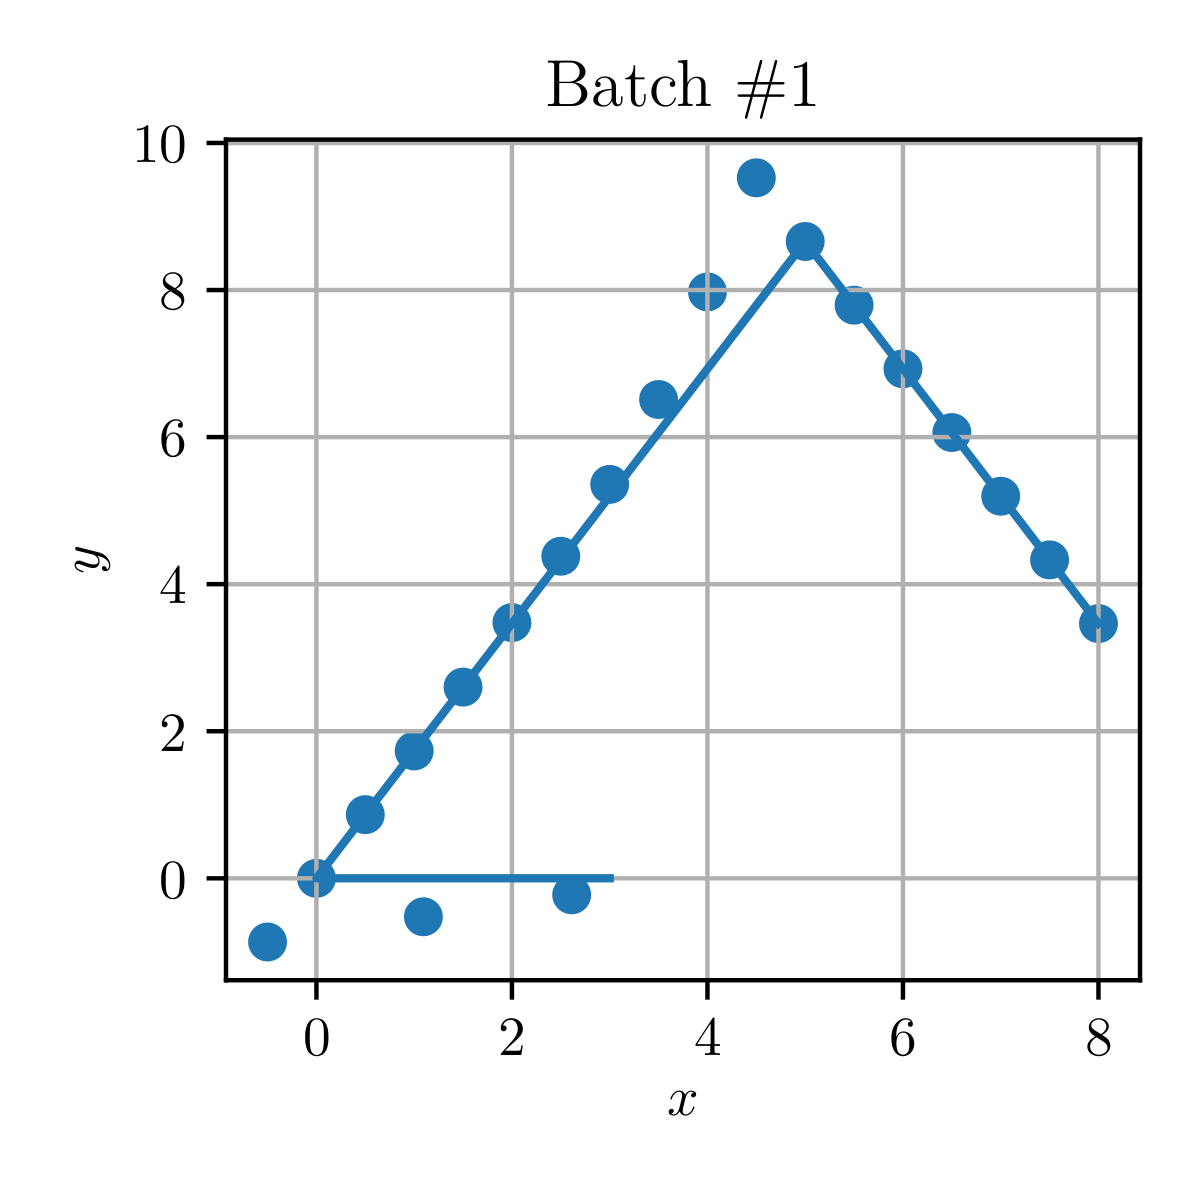
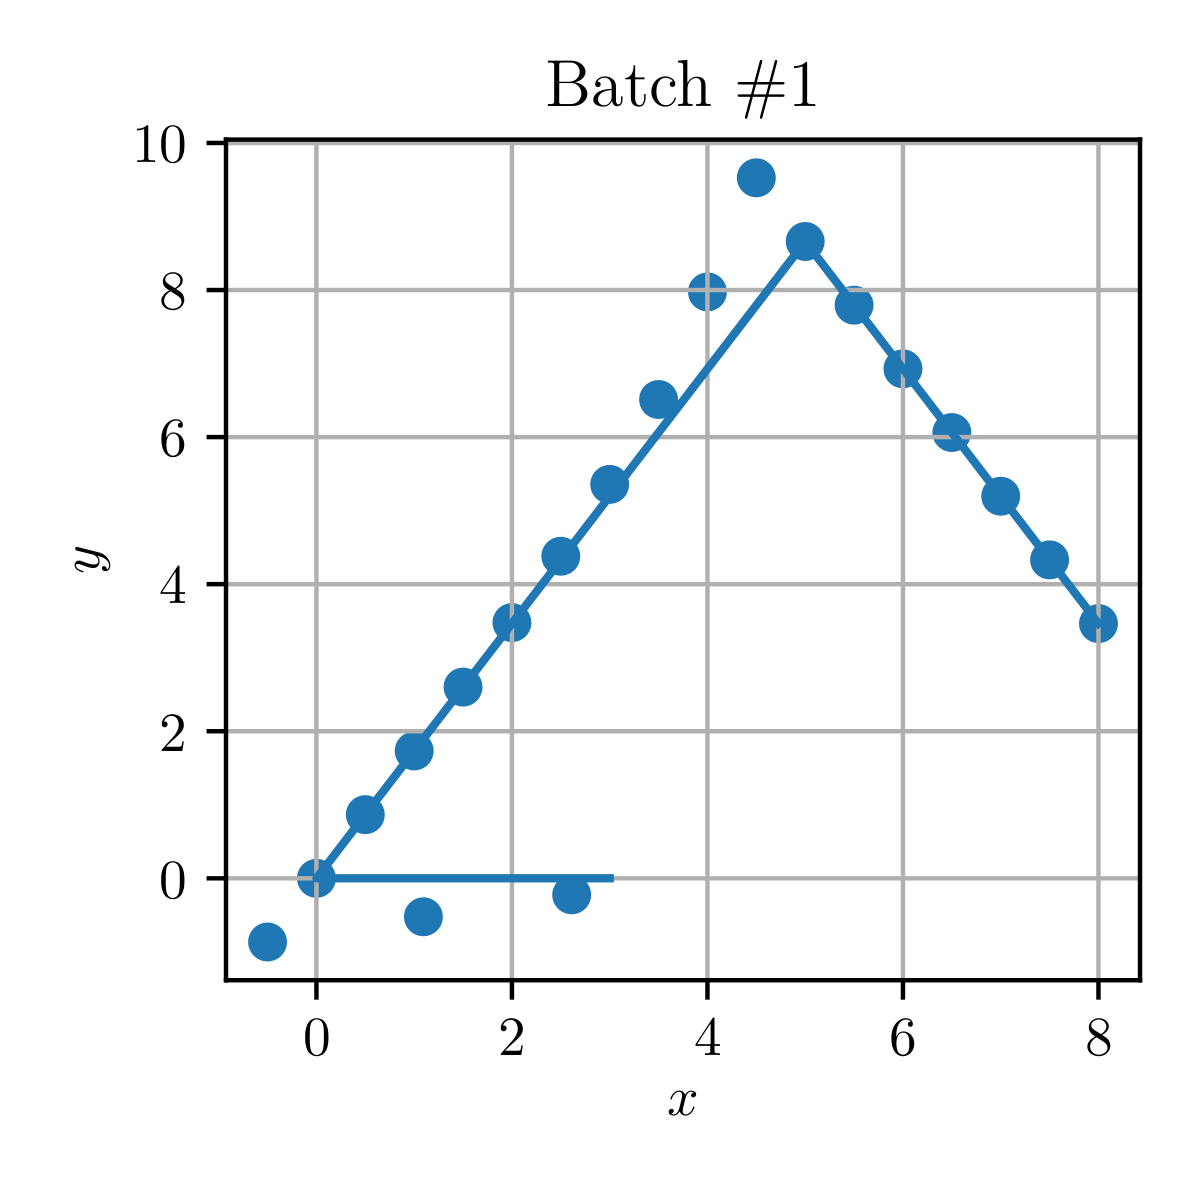
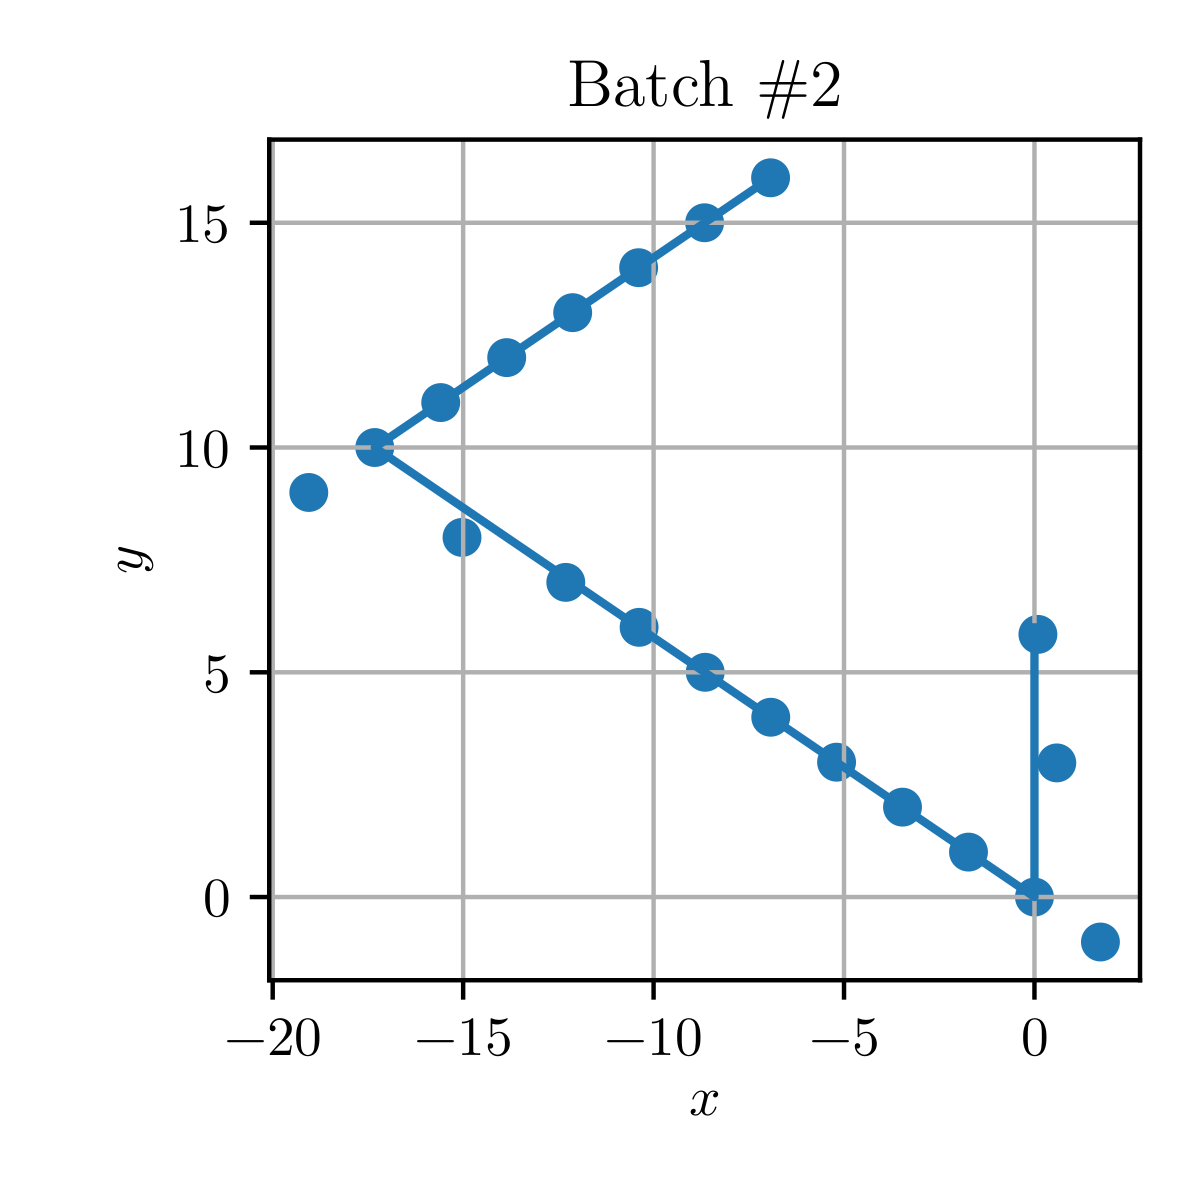
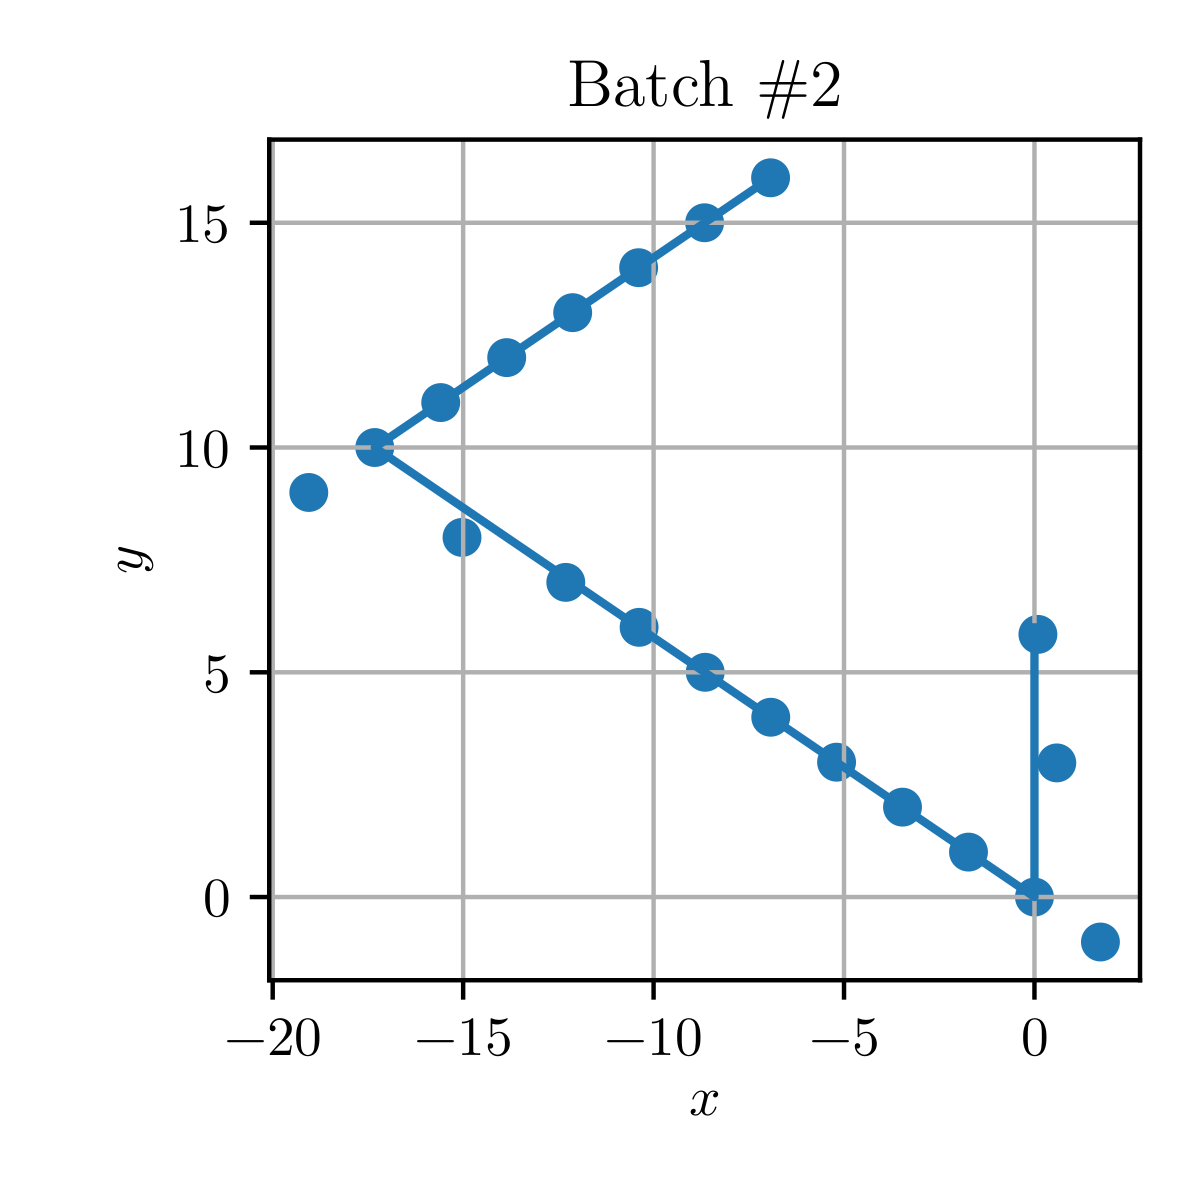
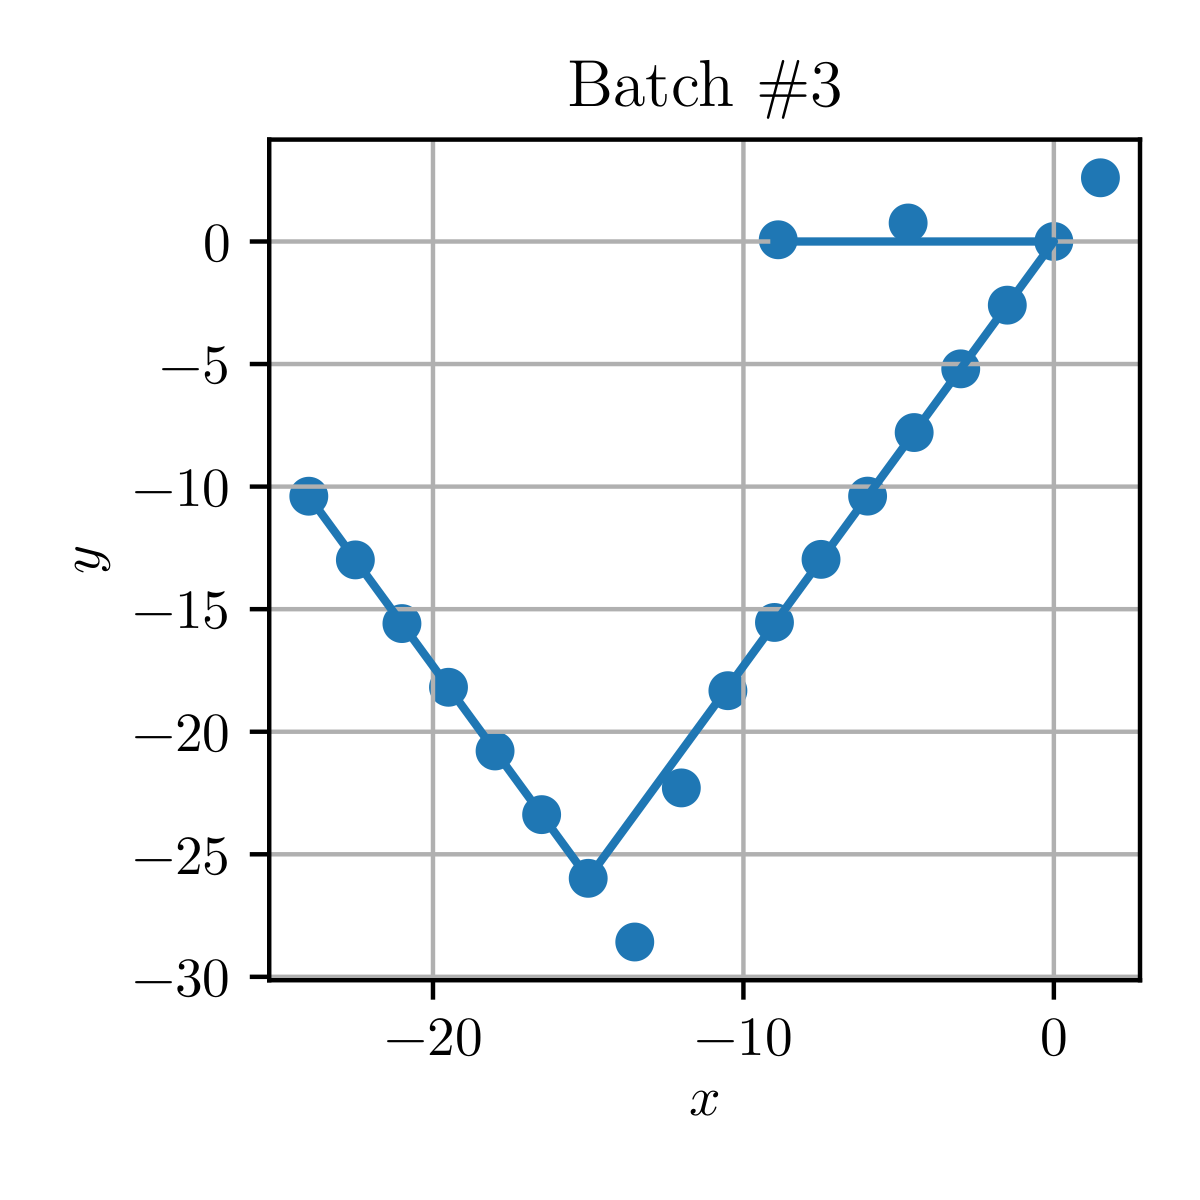
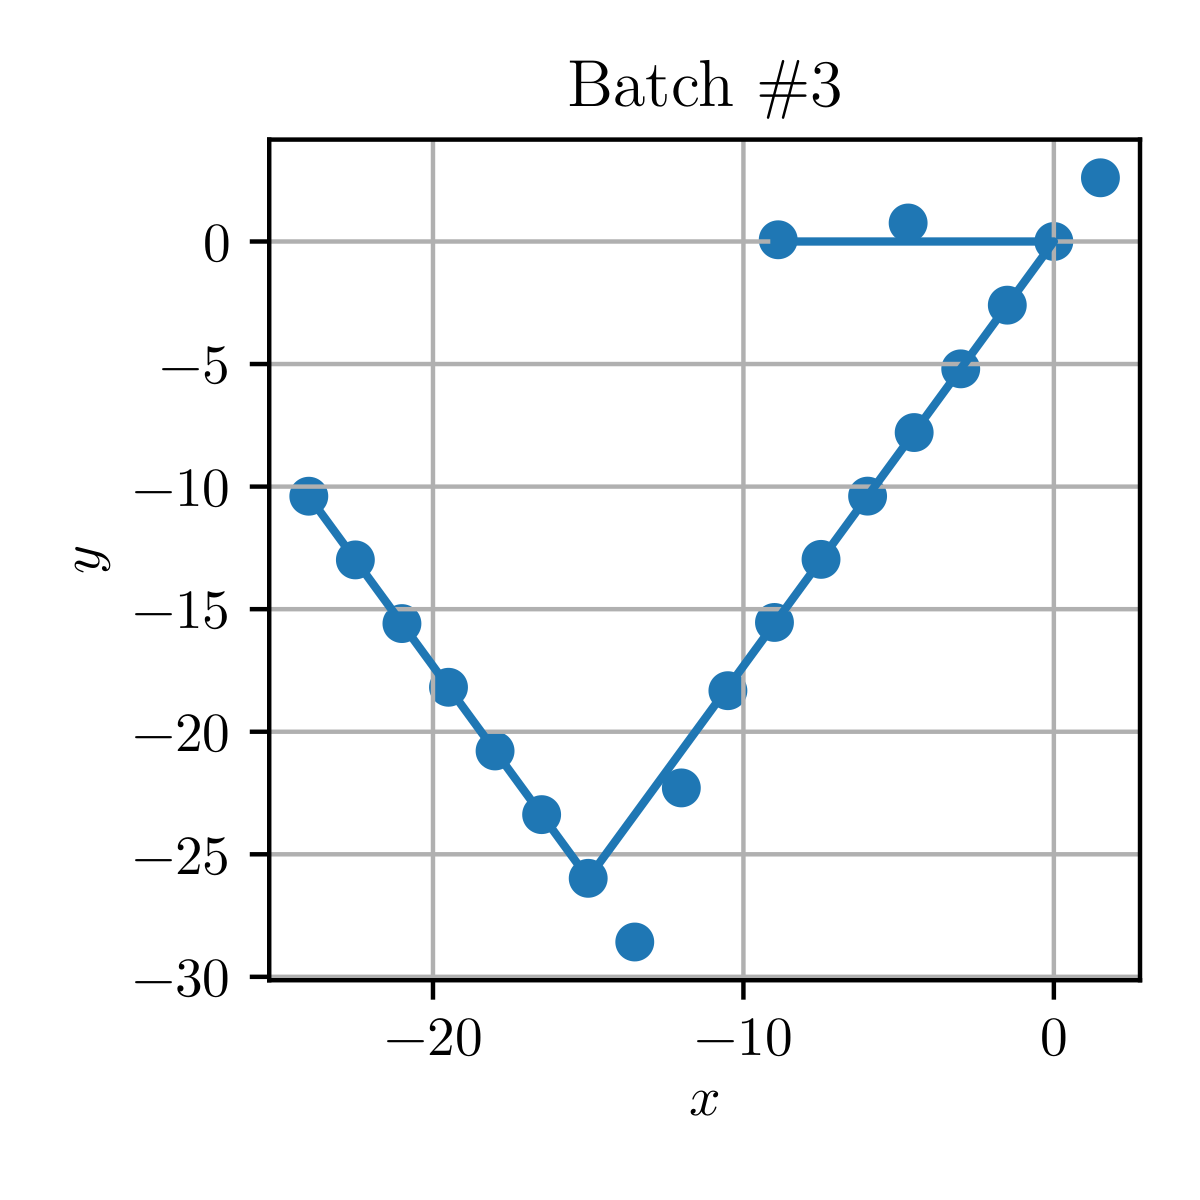
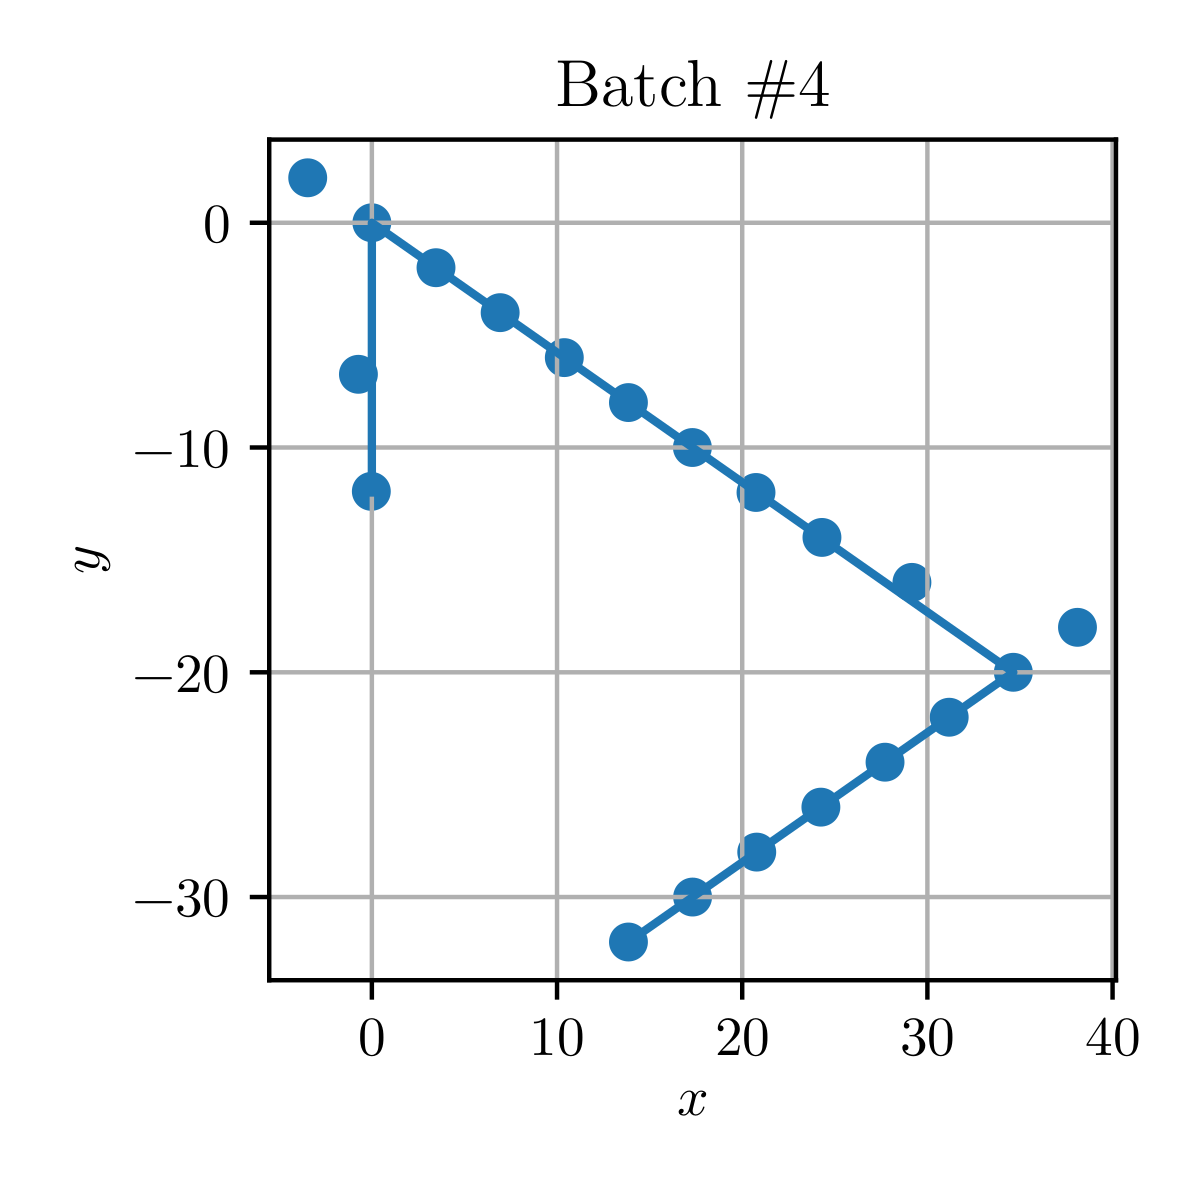
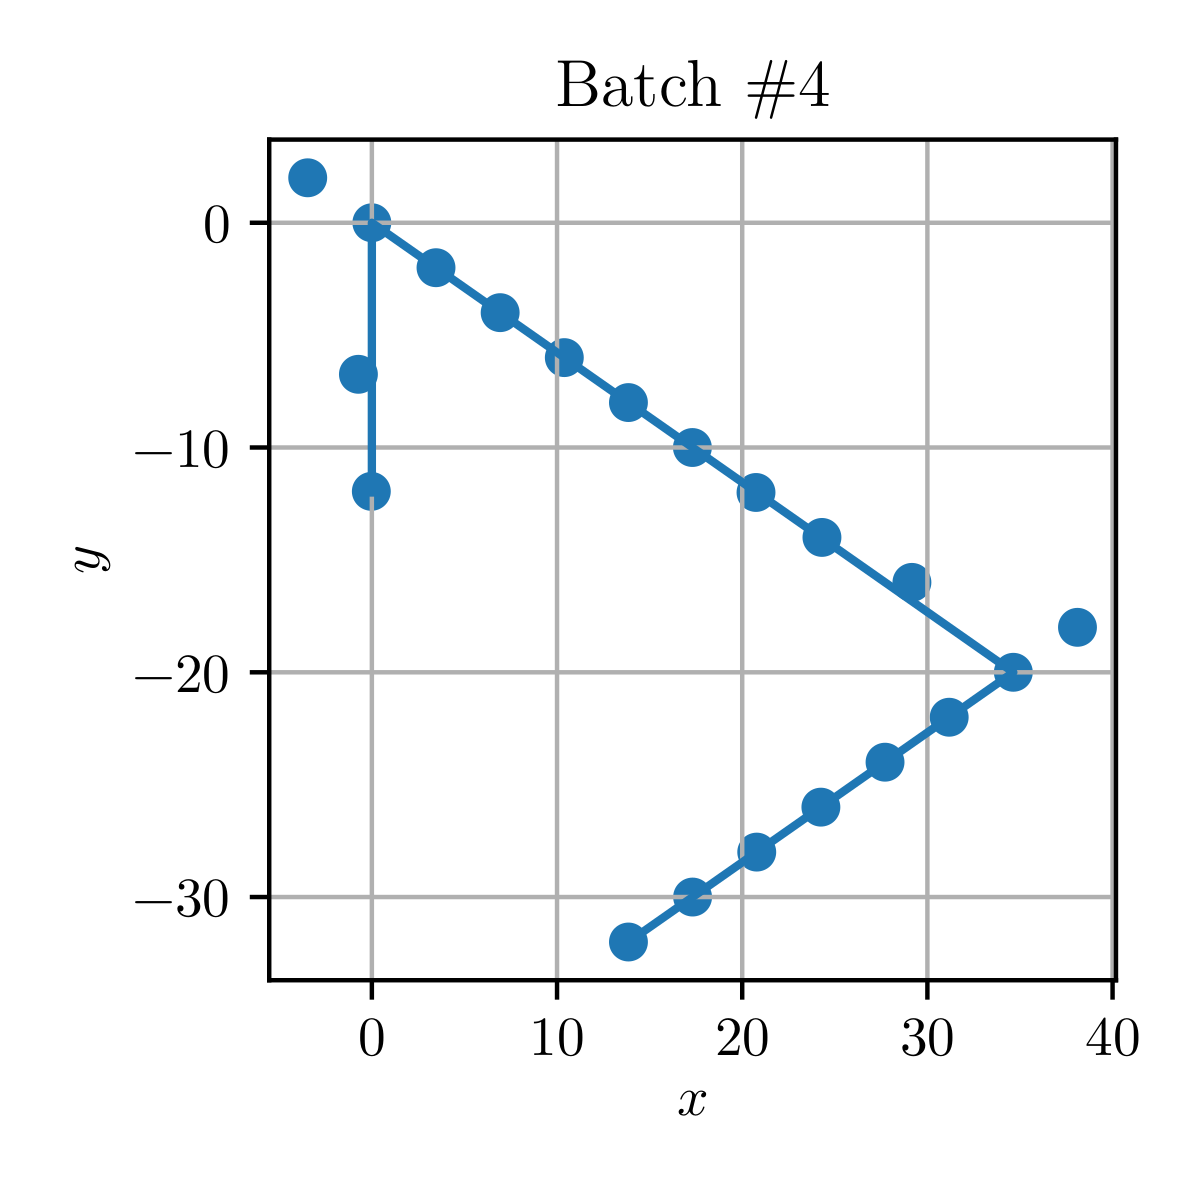

In [13]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 0, 'pred_b1_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 1, 'pred_b2_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 2, 'pred_b3_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 3, 'pred_b4_train'),
], n_columns=4)

[Download loss_b1_train.png],[Download loss_b2_train.png],[Download loss_b3_train.png],[Download loss_b4_train.png]

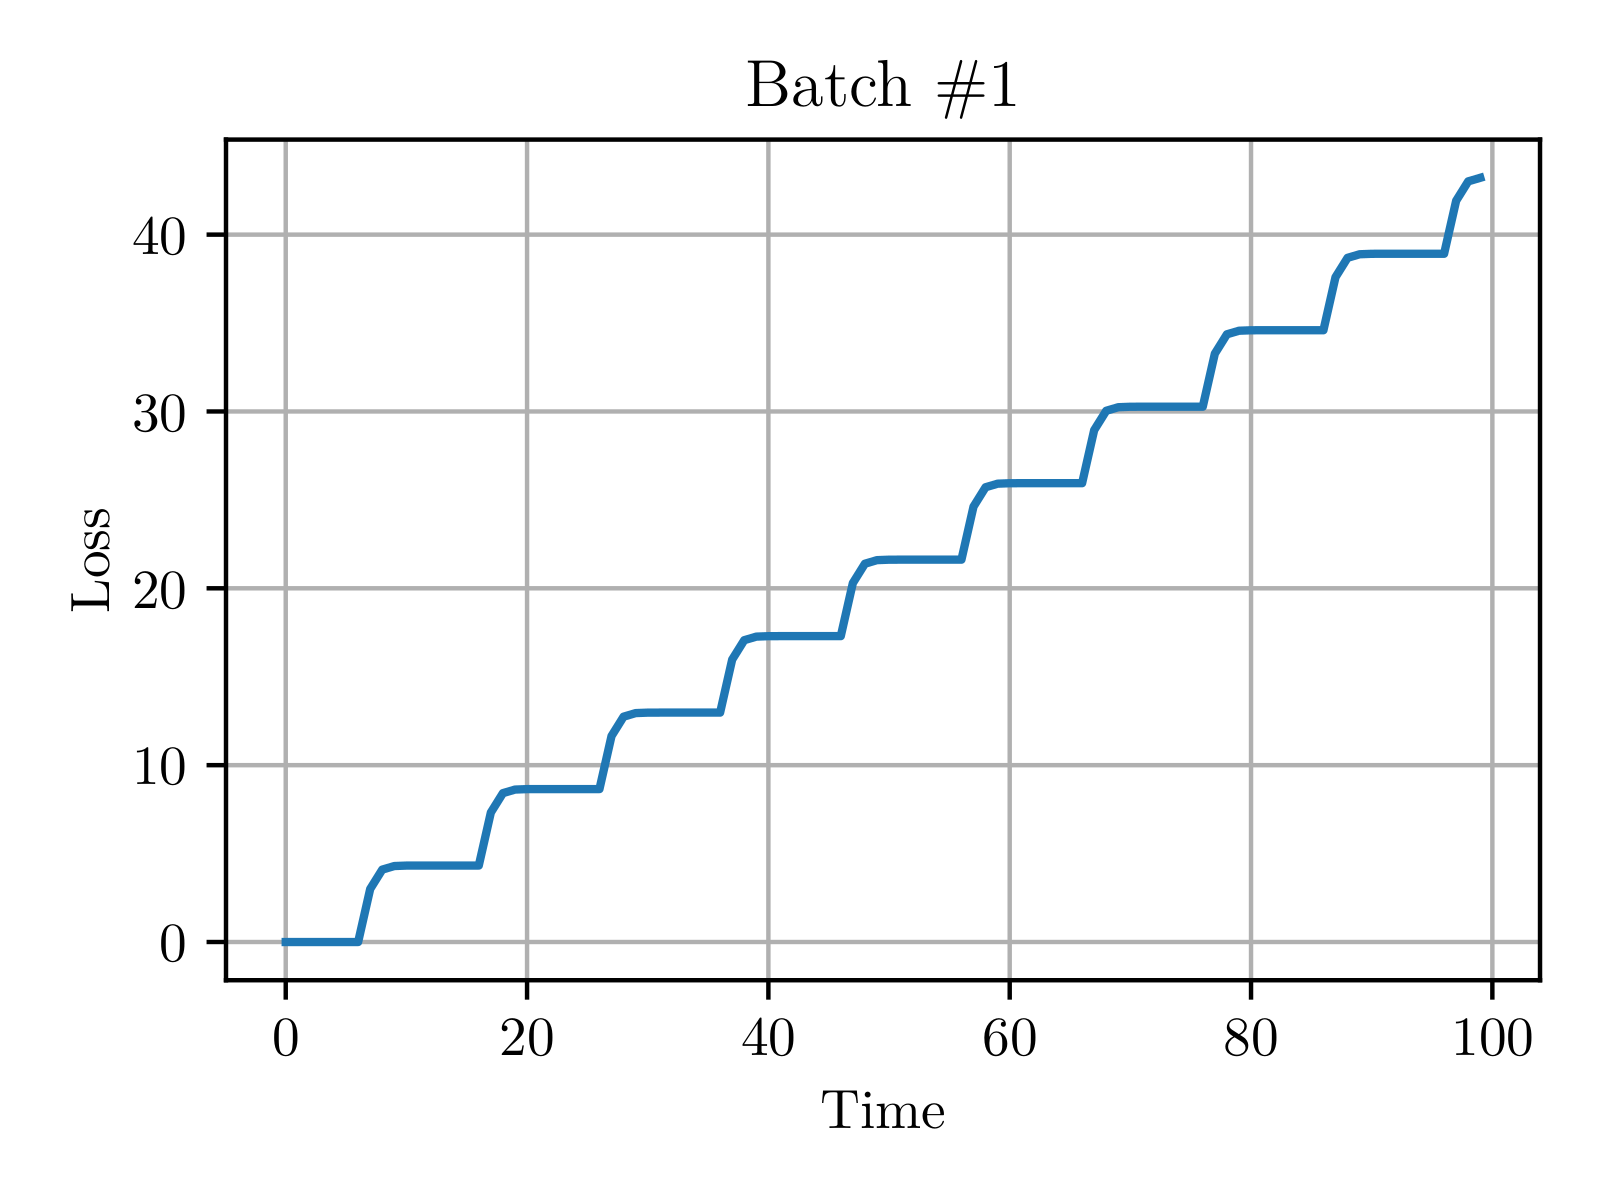
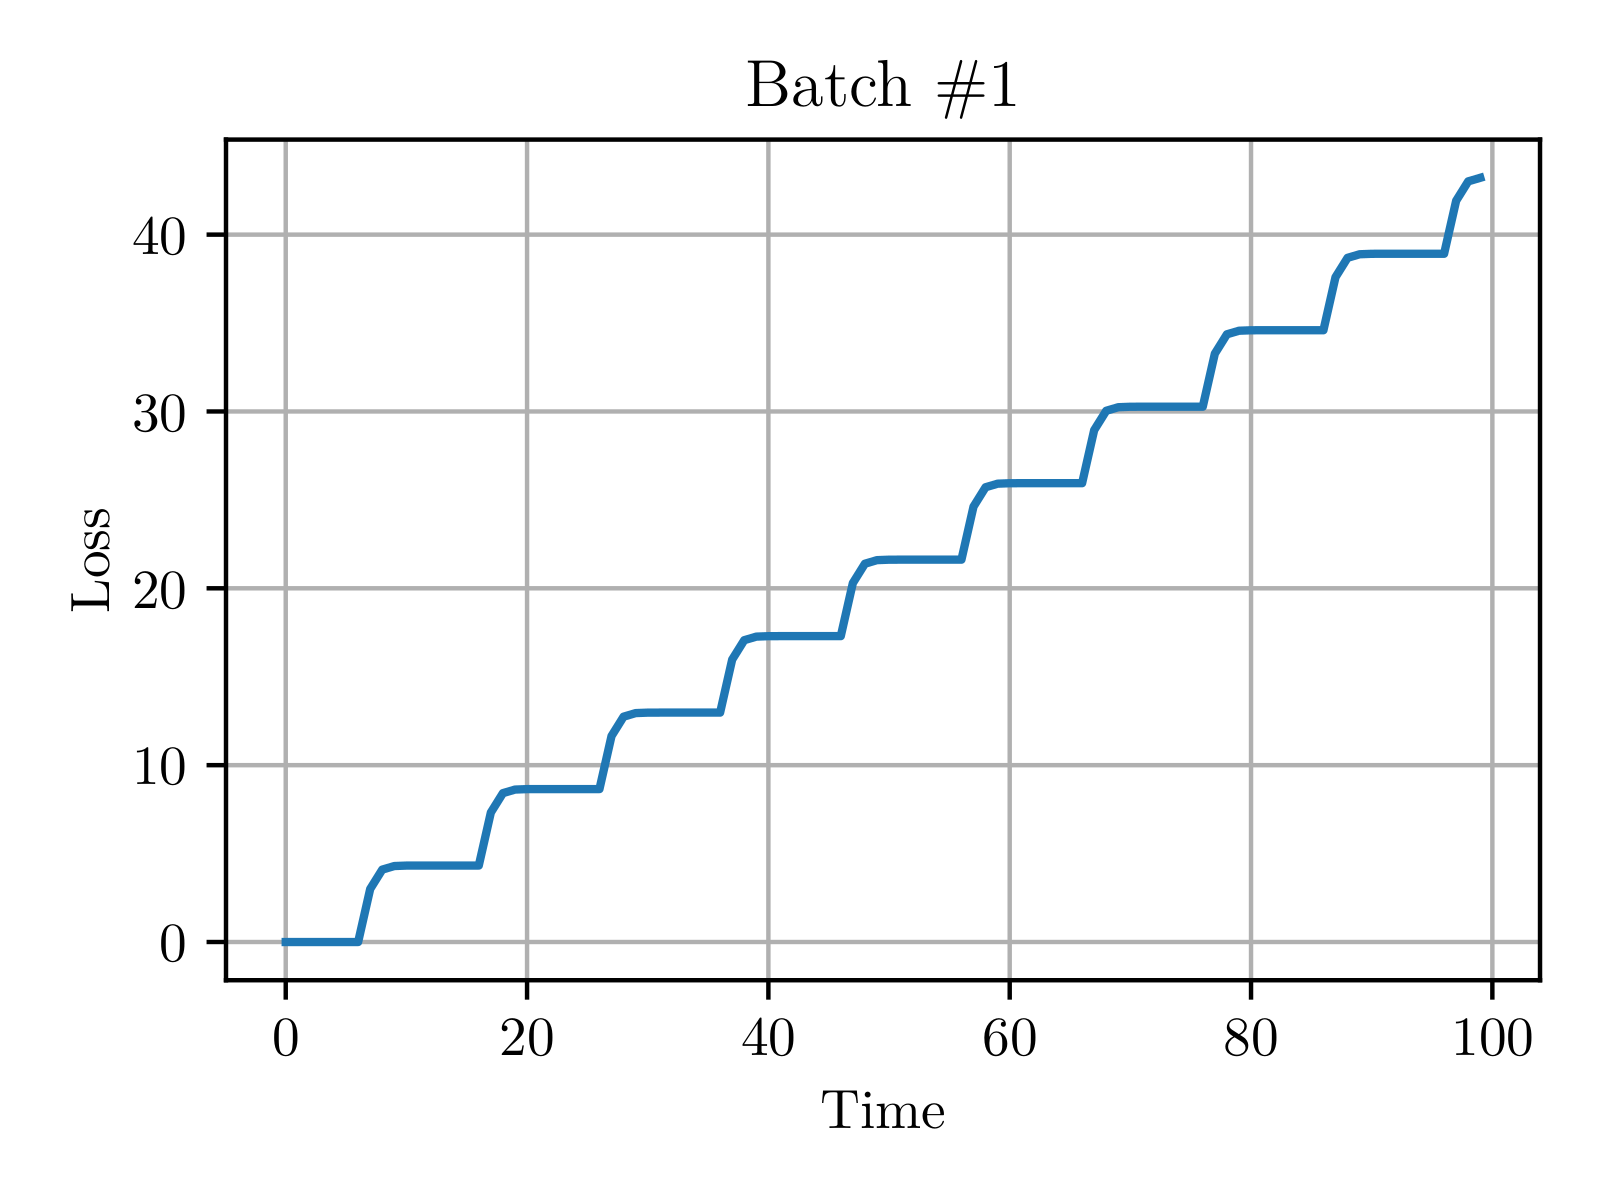
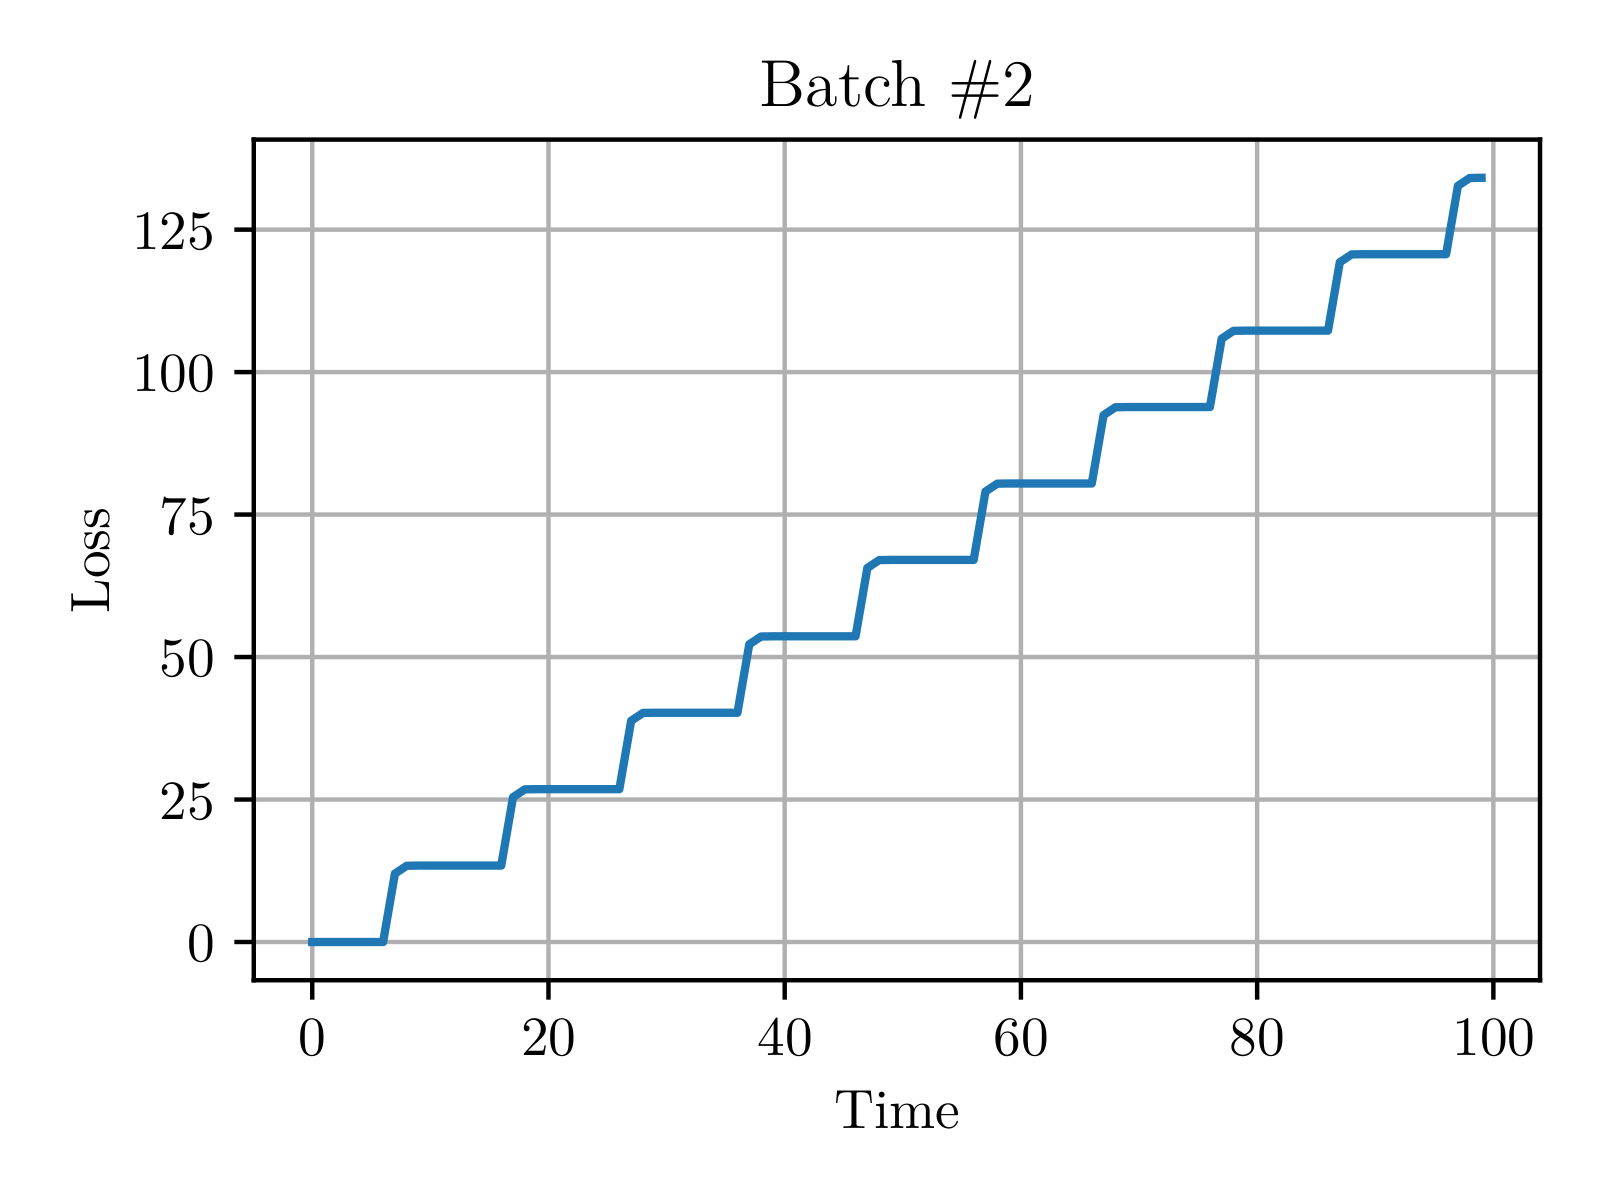
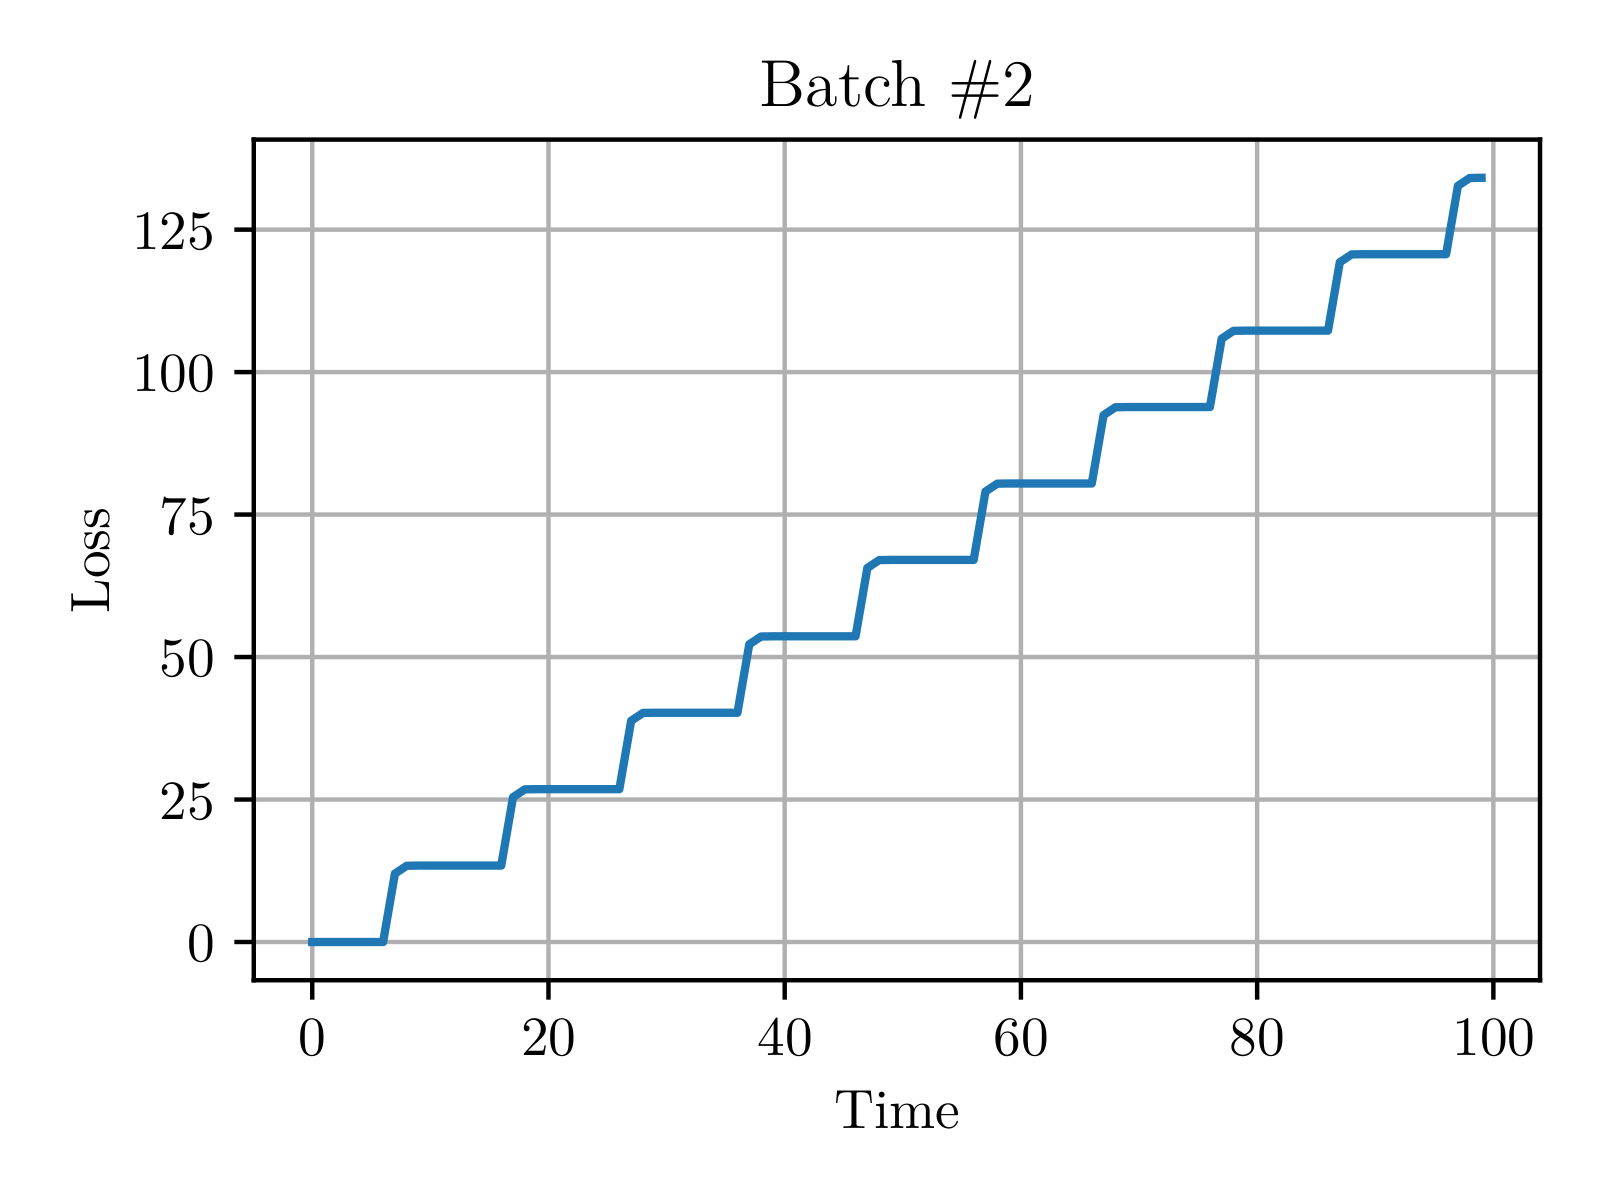
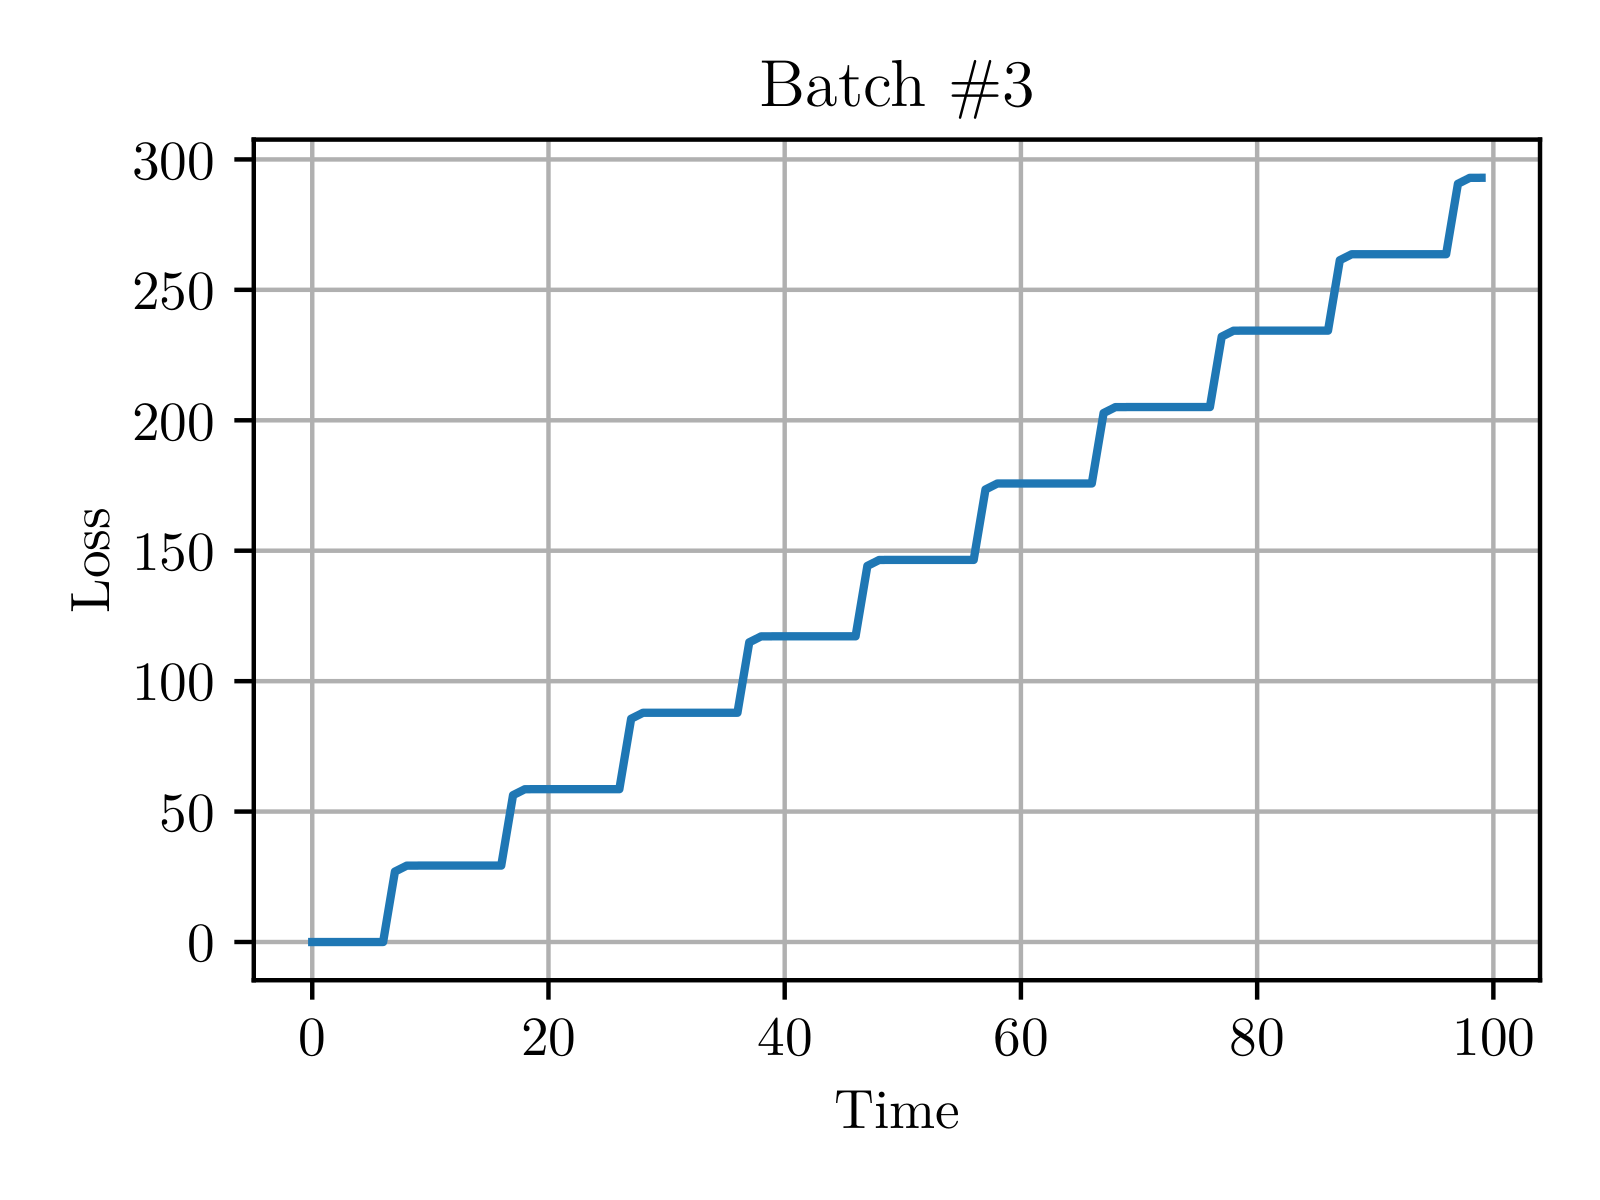
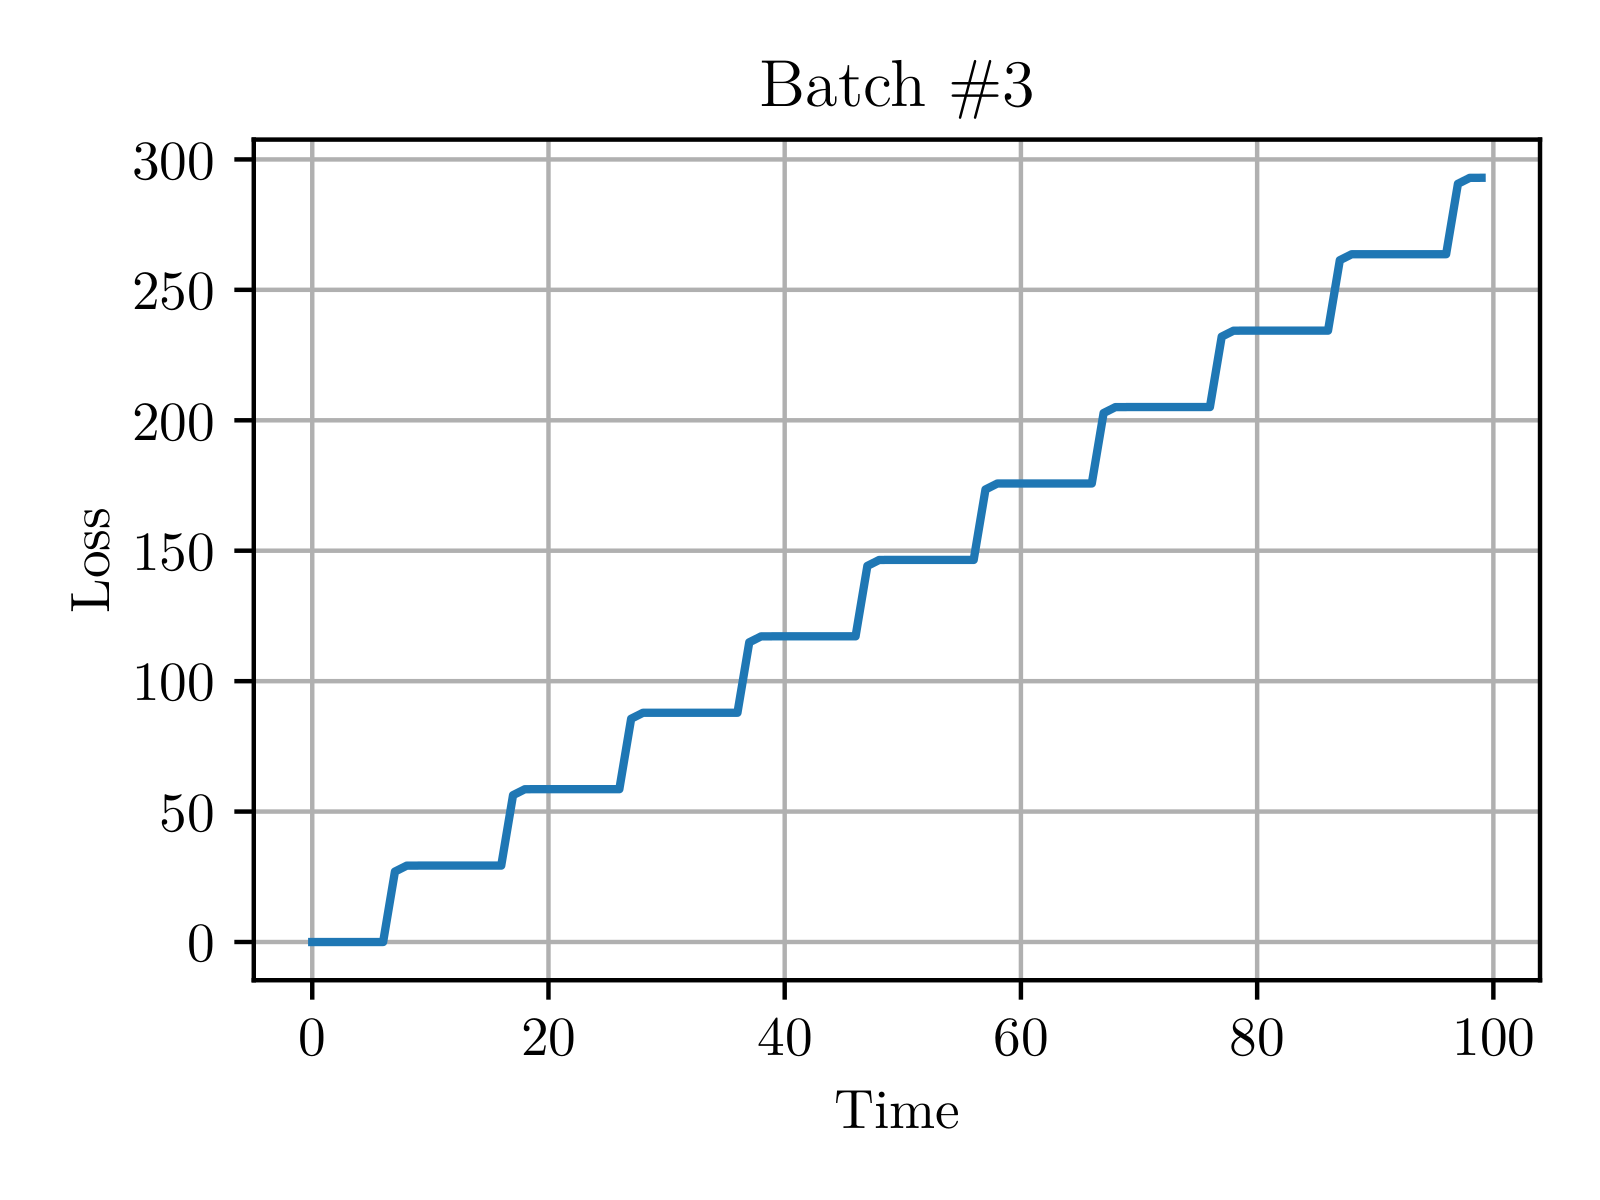
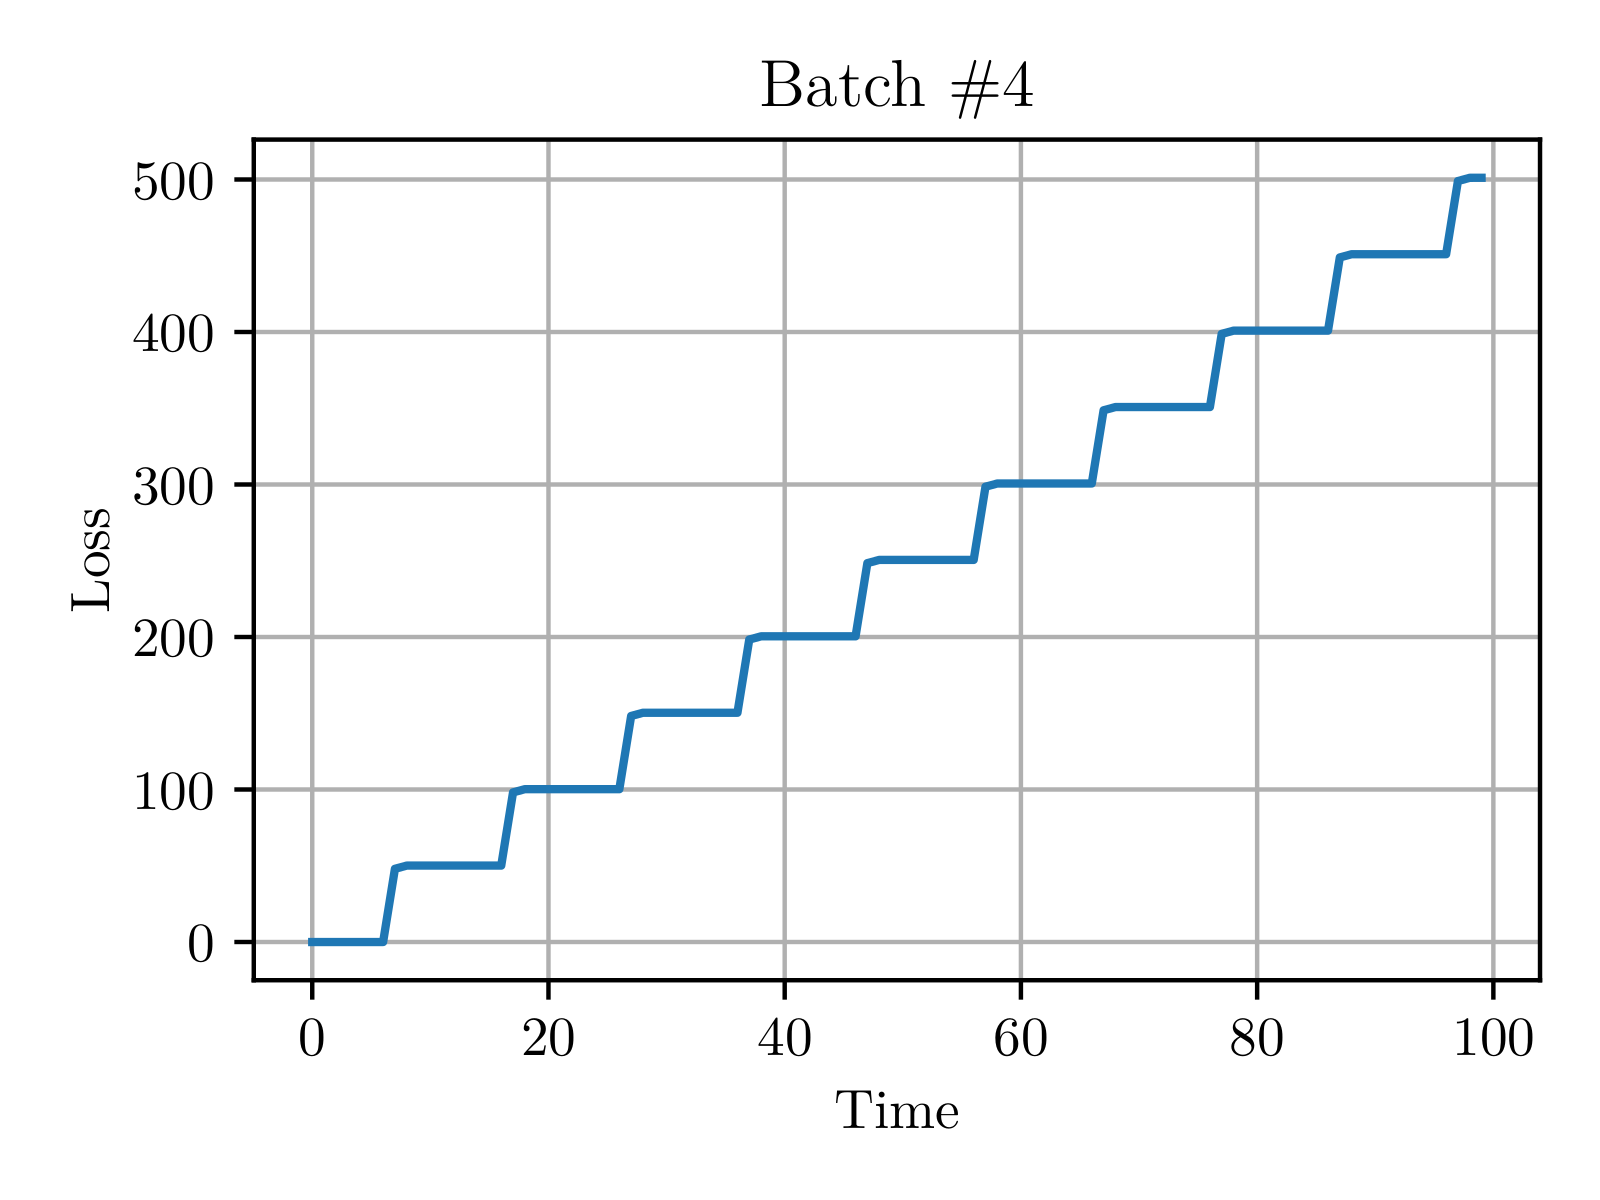
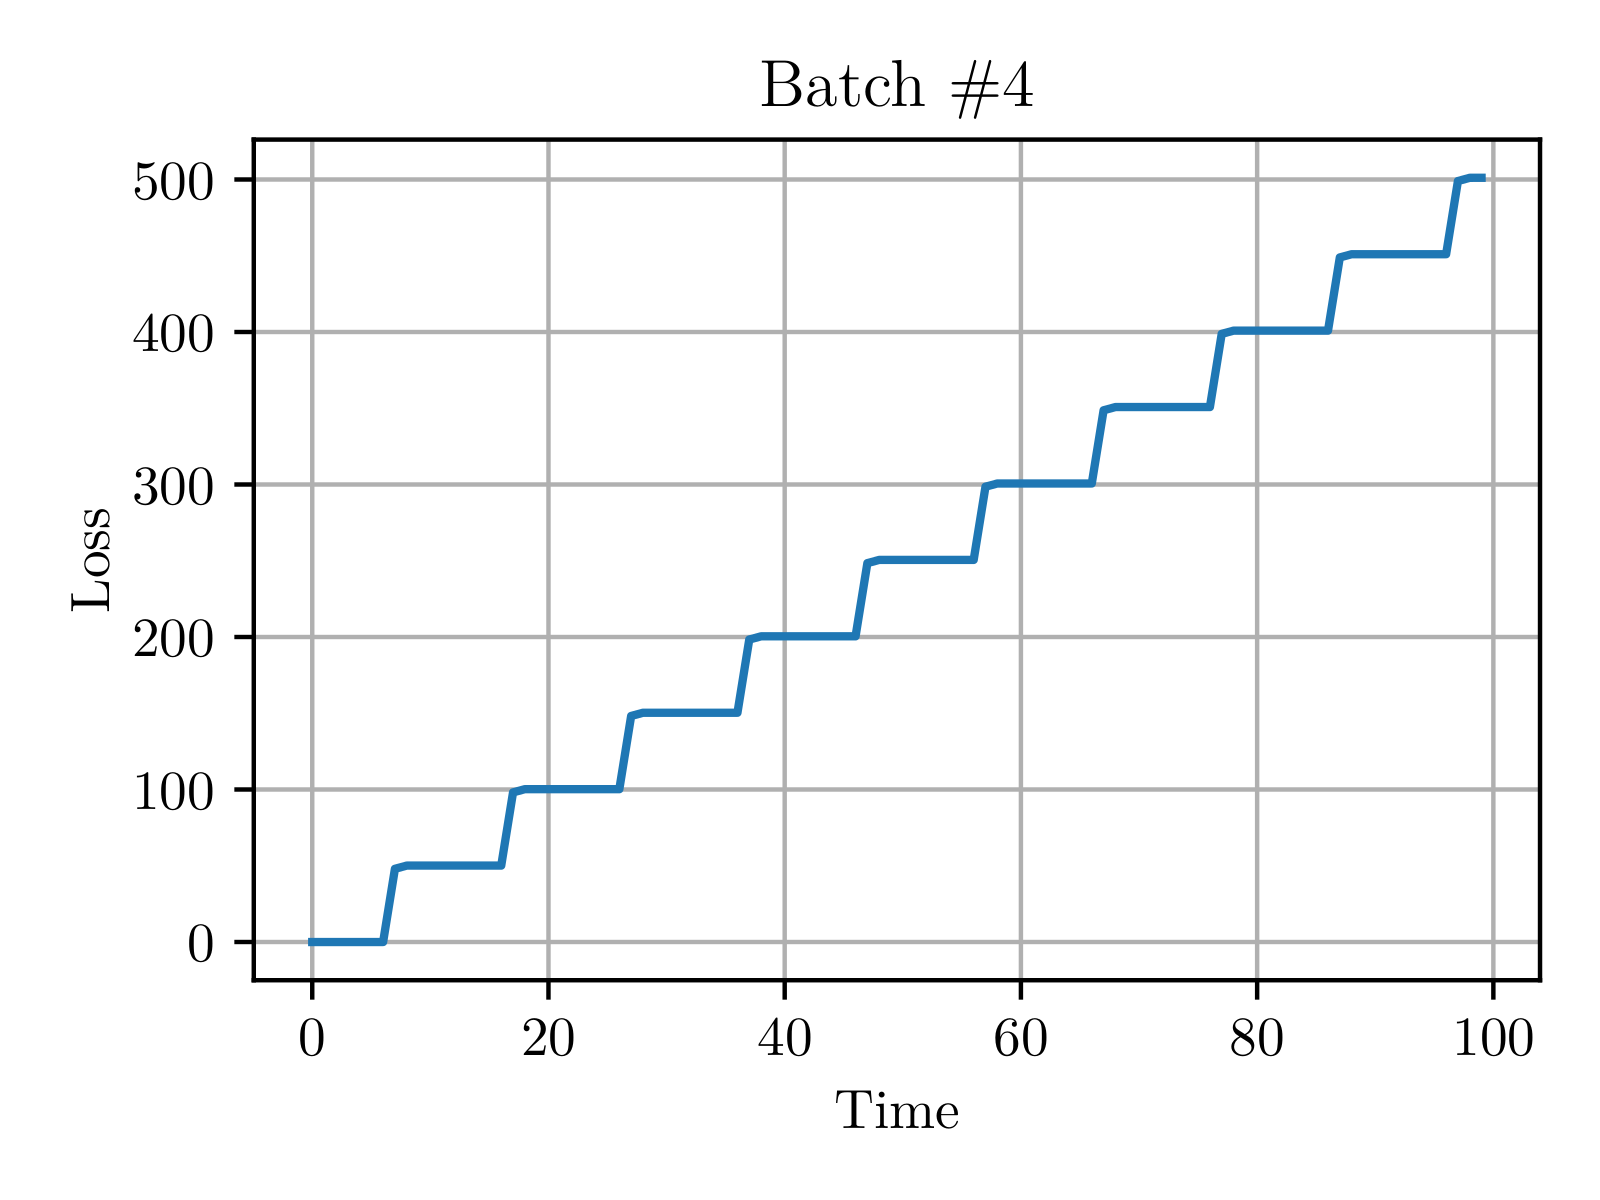

In [14]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X[:, :, -1] - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses, 0, 'loss_b1_train'),
    plot(losses, 1, 'loss_b2_train'),
    plot(losses, 2, 'loss_b3_train'),
    plot(losses, 3, 'loss_b4_train'),
], n_columns=4)

In [15]:
X, _ = data_loader()

In [16]:
X_pred = evaluate(X, state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
X_pred.shape

torch.Size([4, 2, 210])

[Download pred_b1.png],[Download pred_b2.png],[Download pred_b3.png],[Download pred_b4.png]

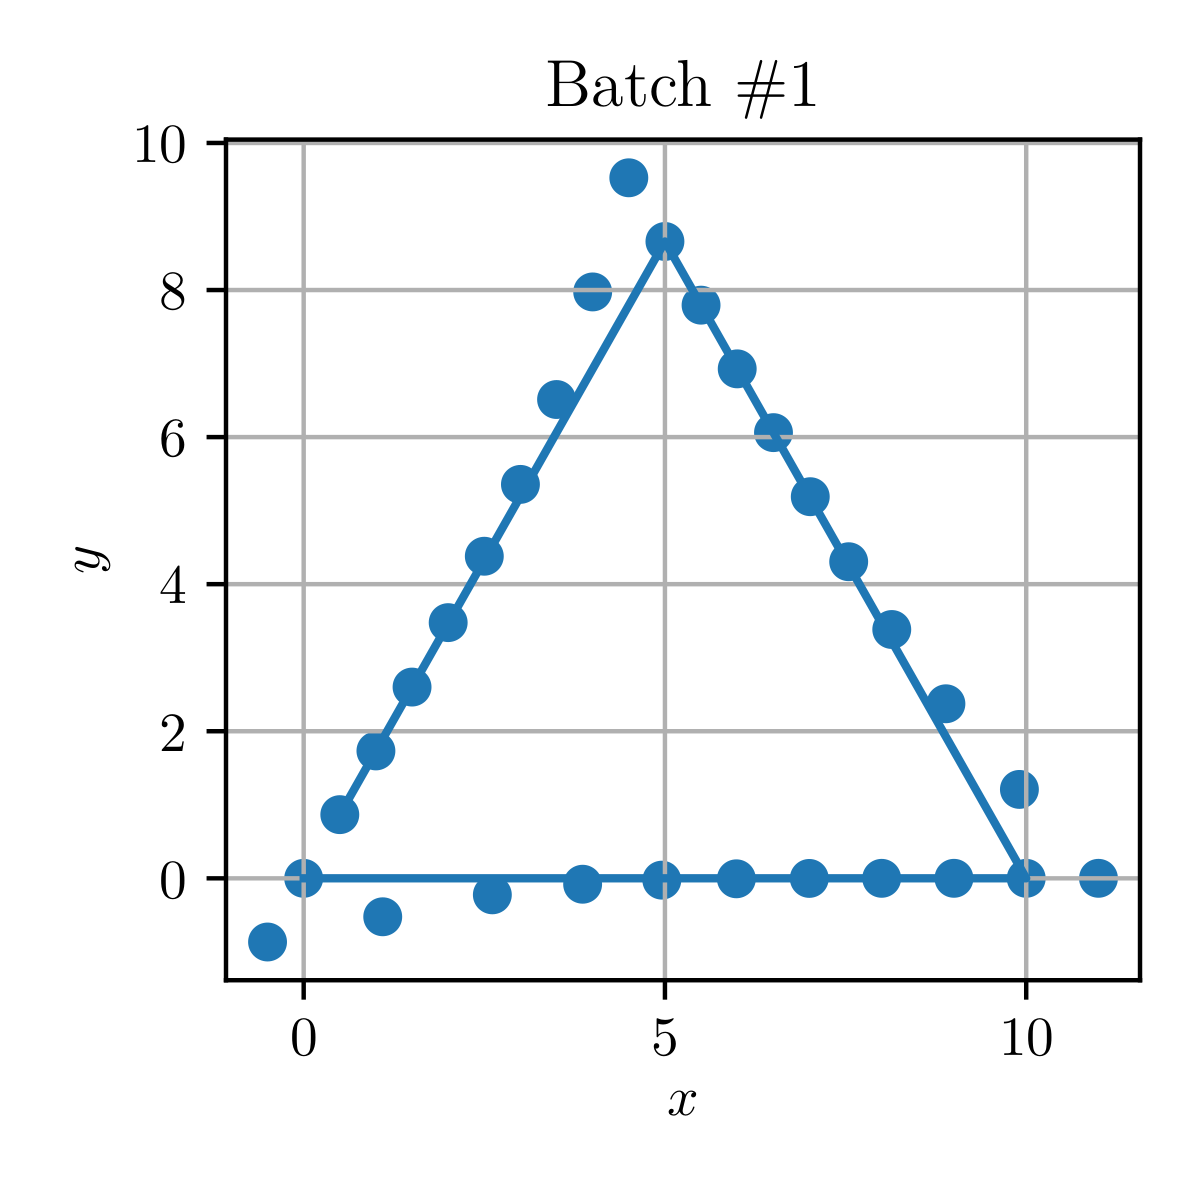
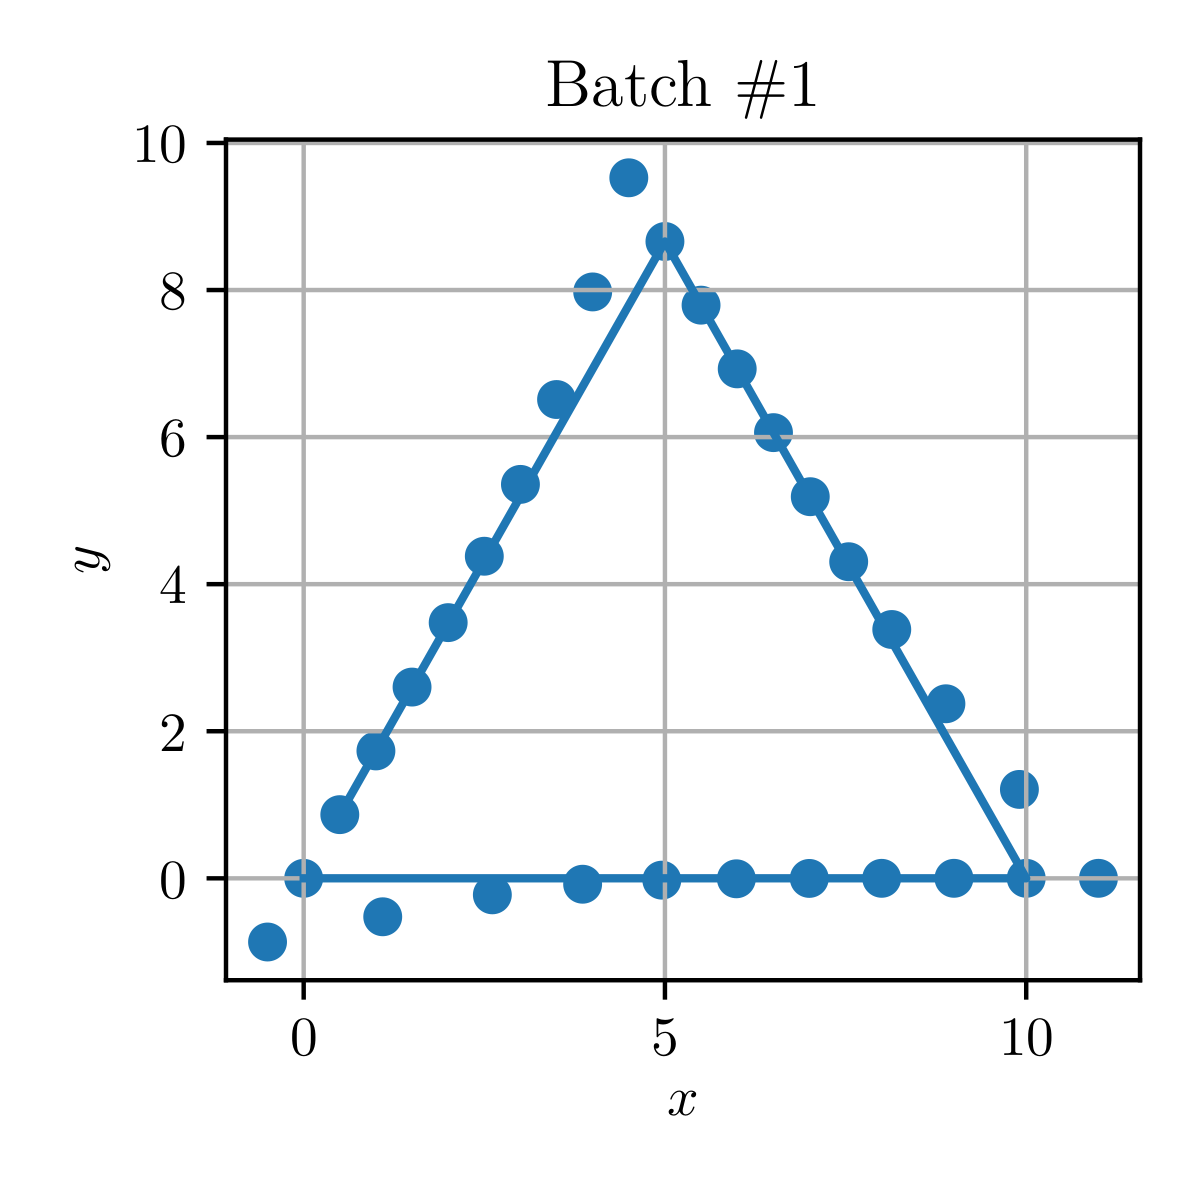
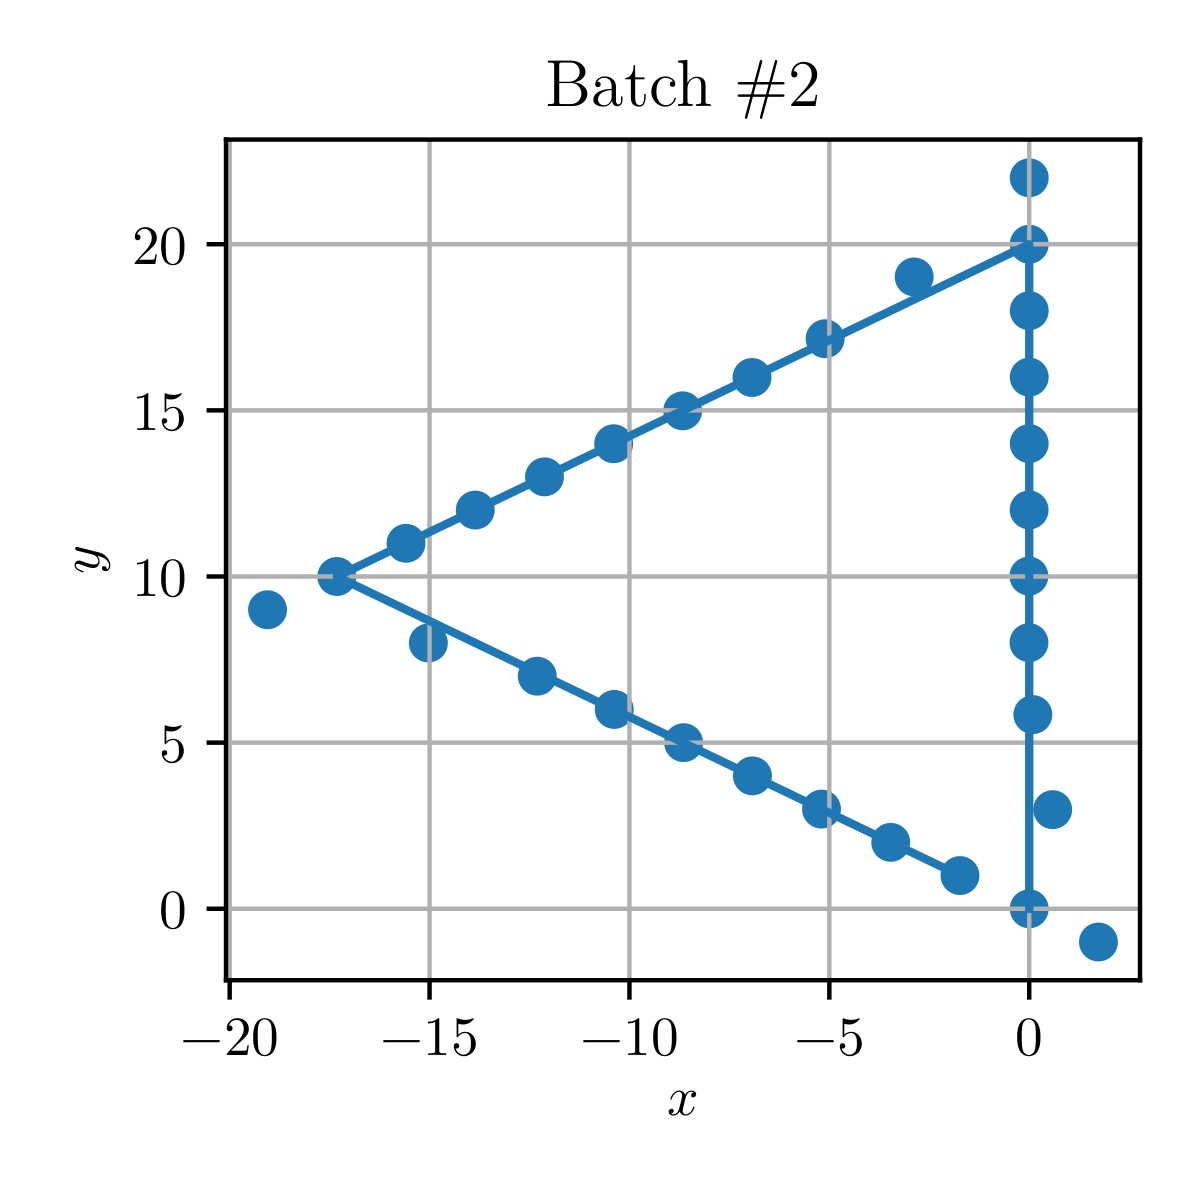
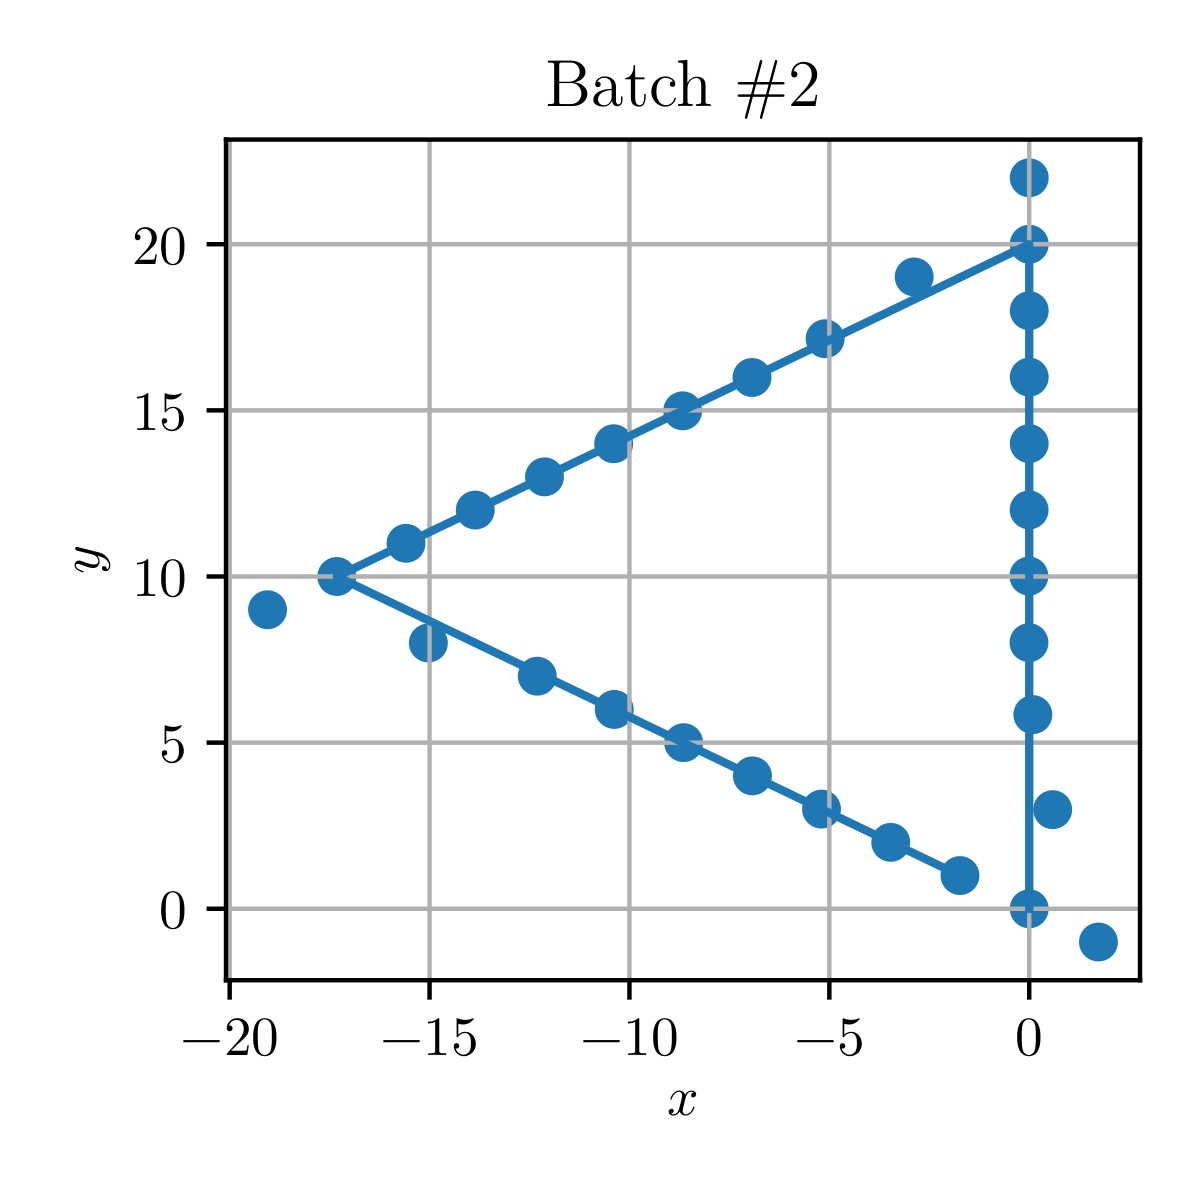
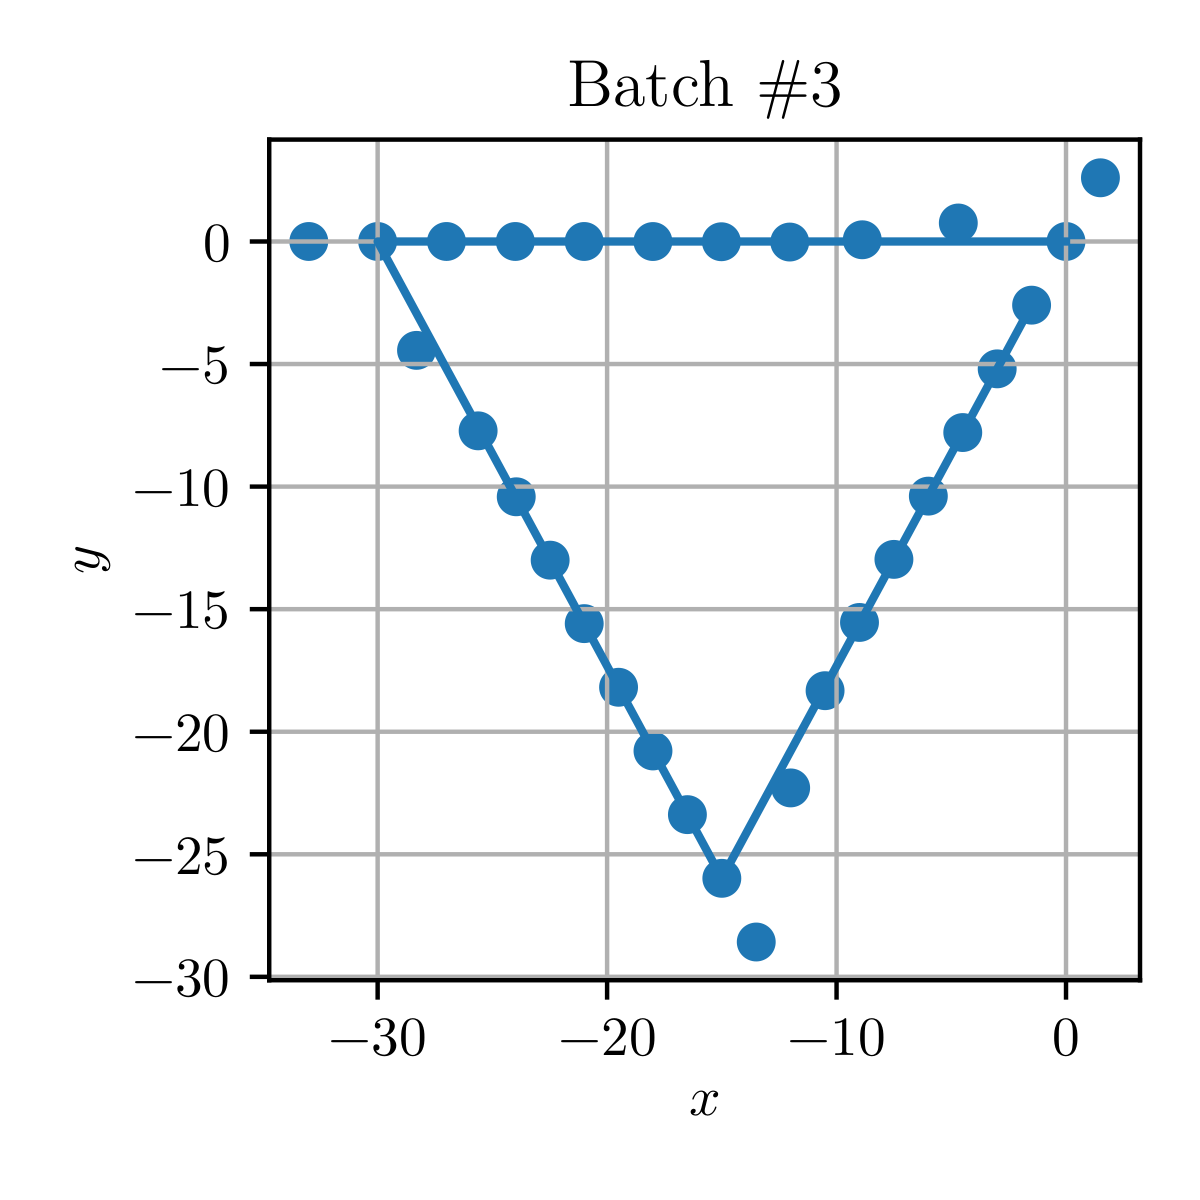
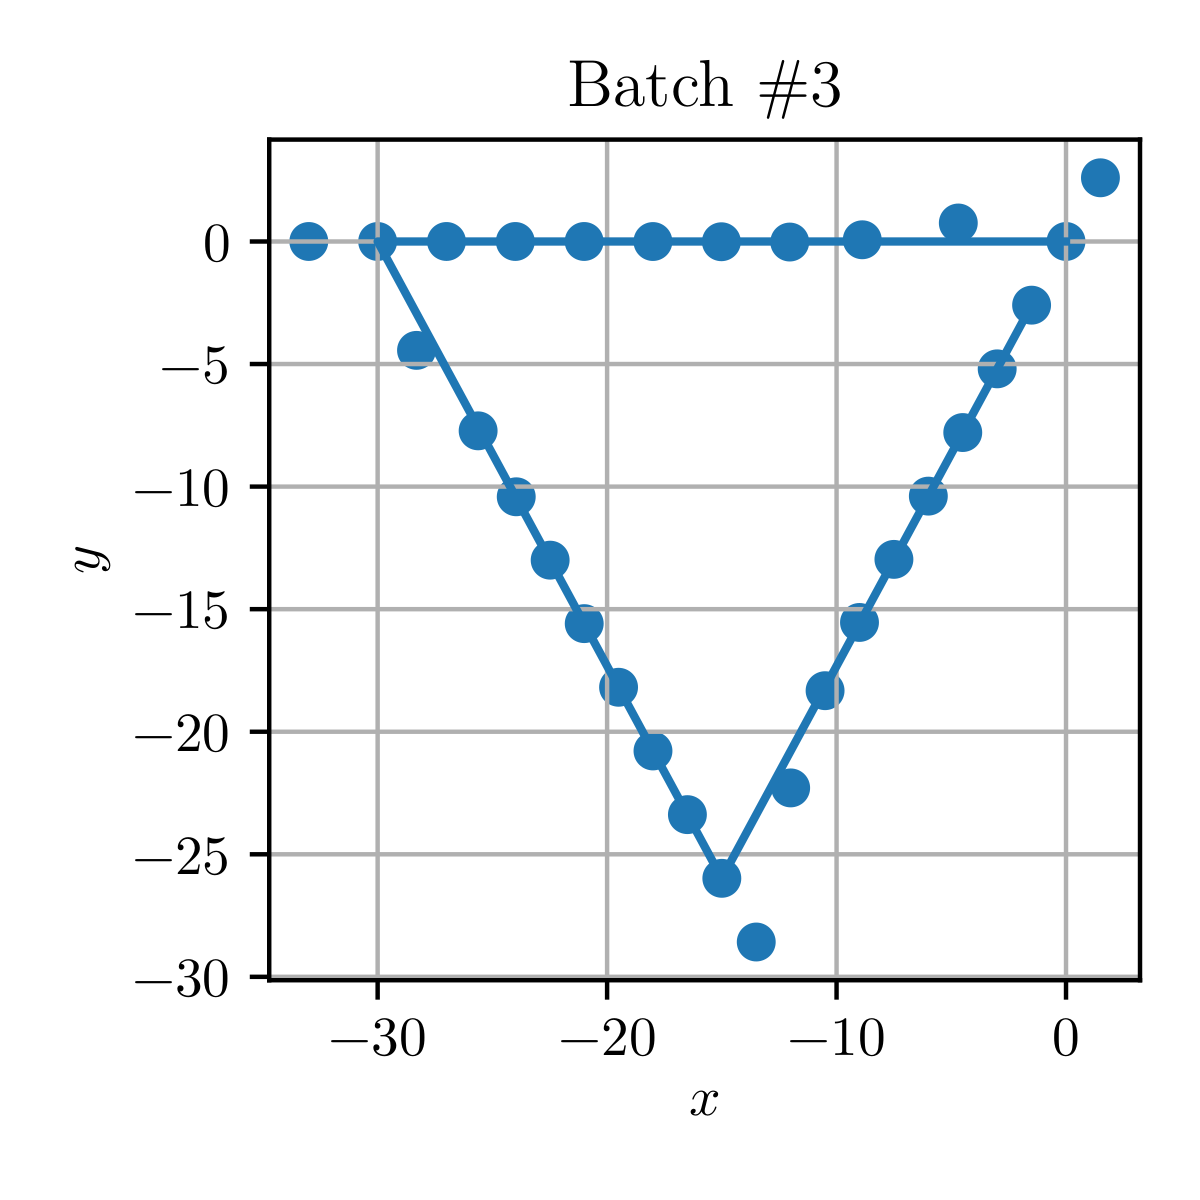
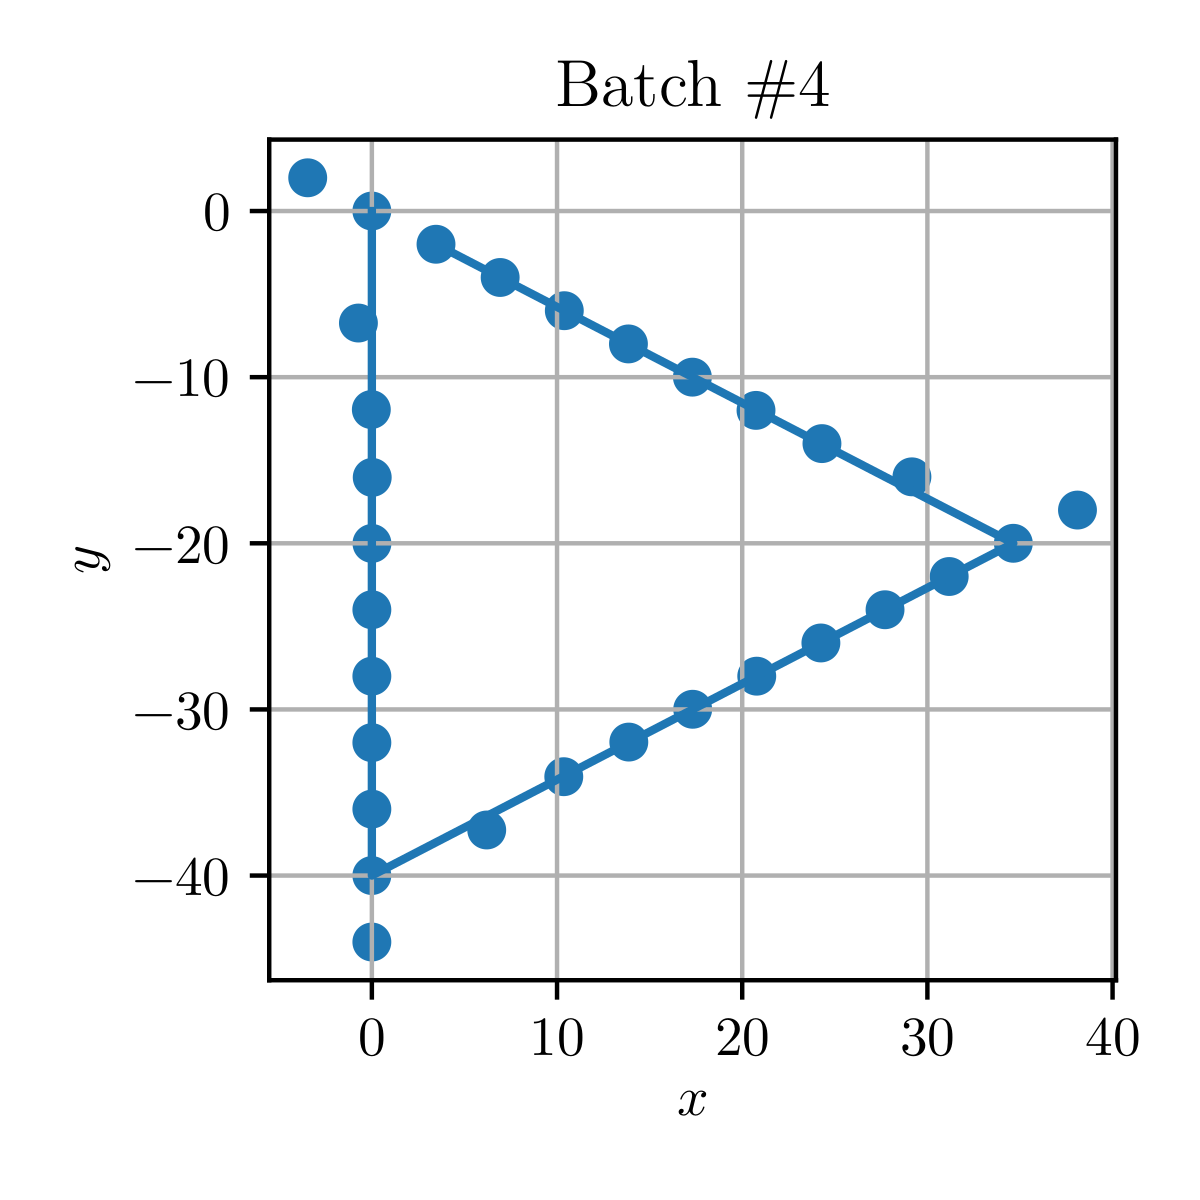
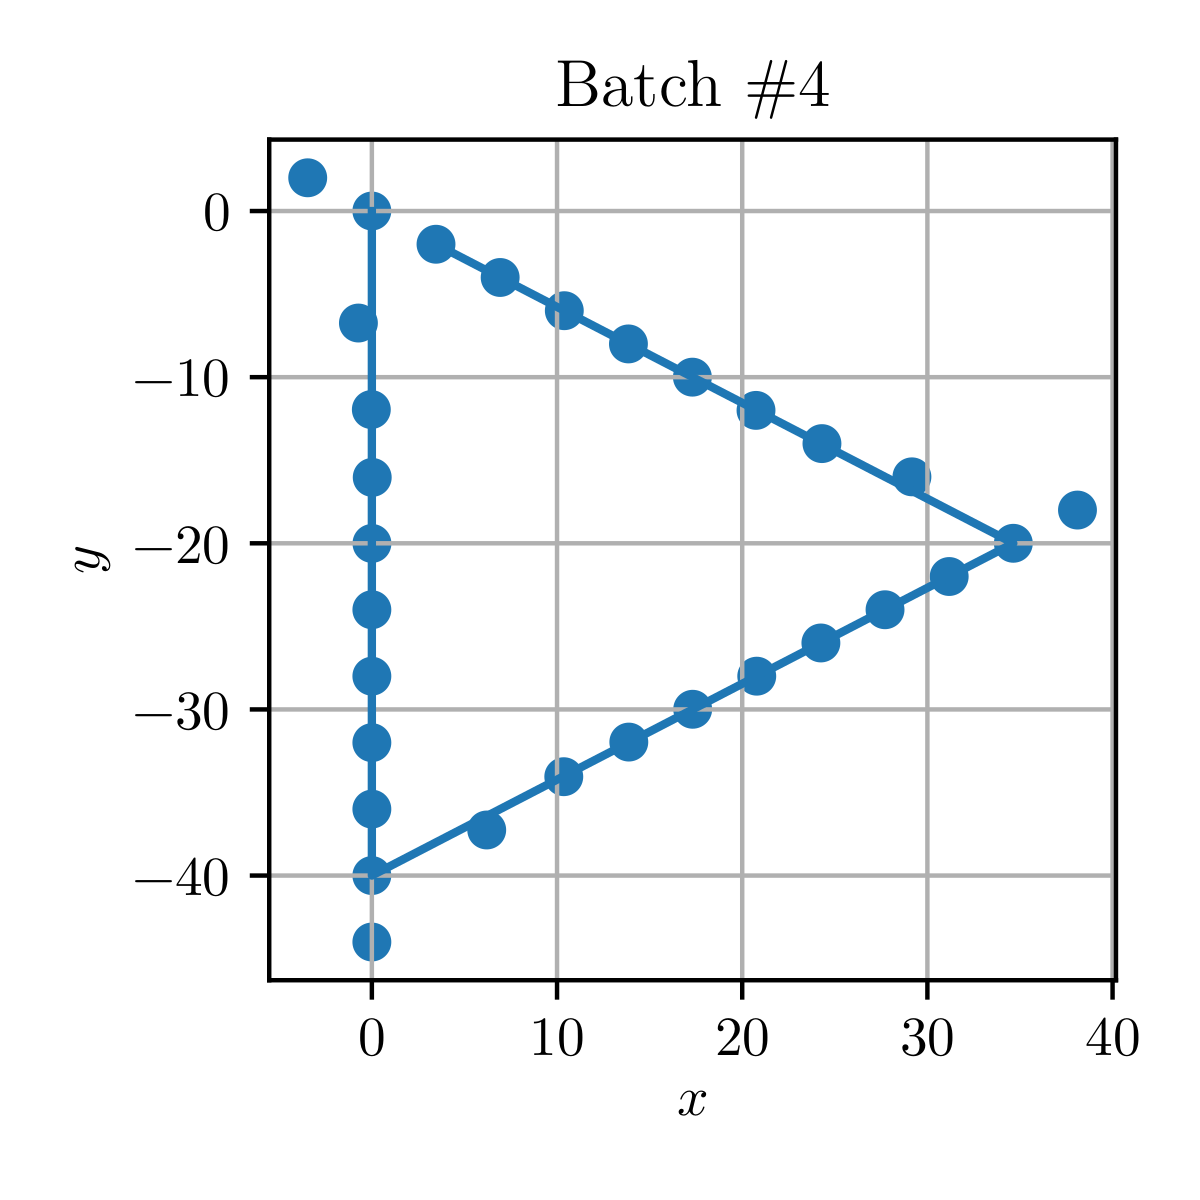

In [17]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, -30:], X[:, :, -30:], 0, 'pred_b1'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 1, 'pred_b2'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 2, 'pred_b3'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 3, 'pred_b4'),
], n_columns=4)

[Download loss_b1.png],[Download loss_b2.png],[Download loss_b3.png],[Download loss_b4.png]

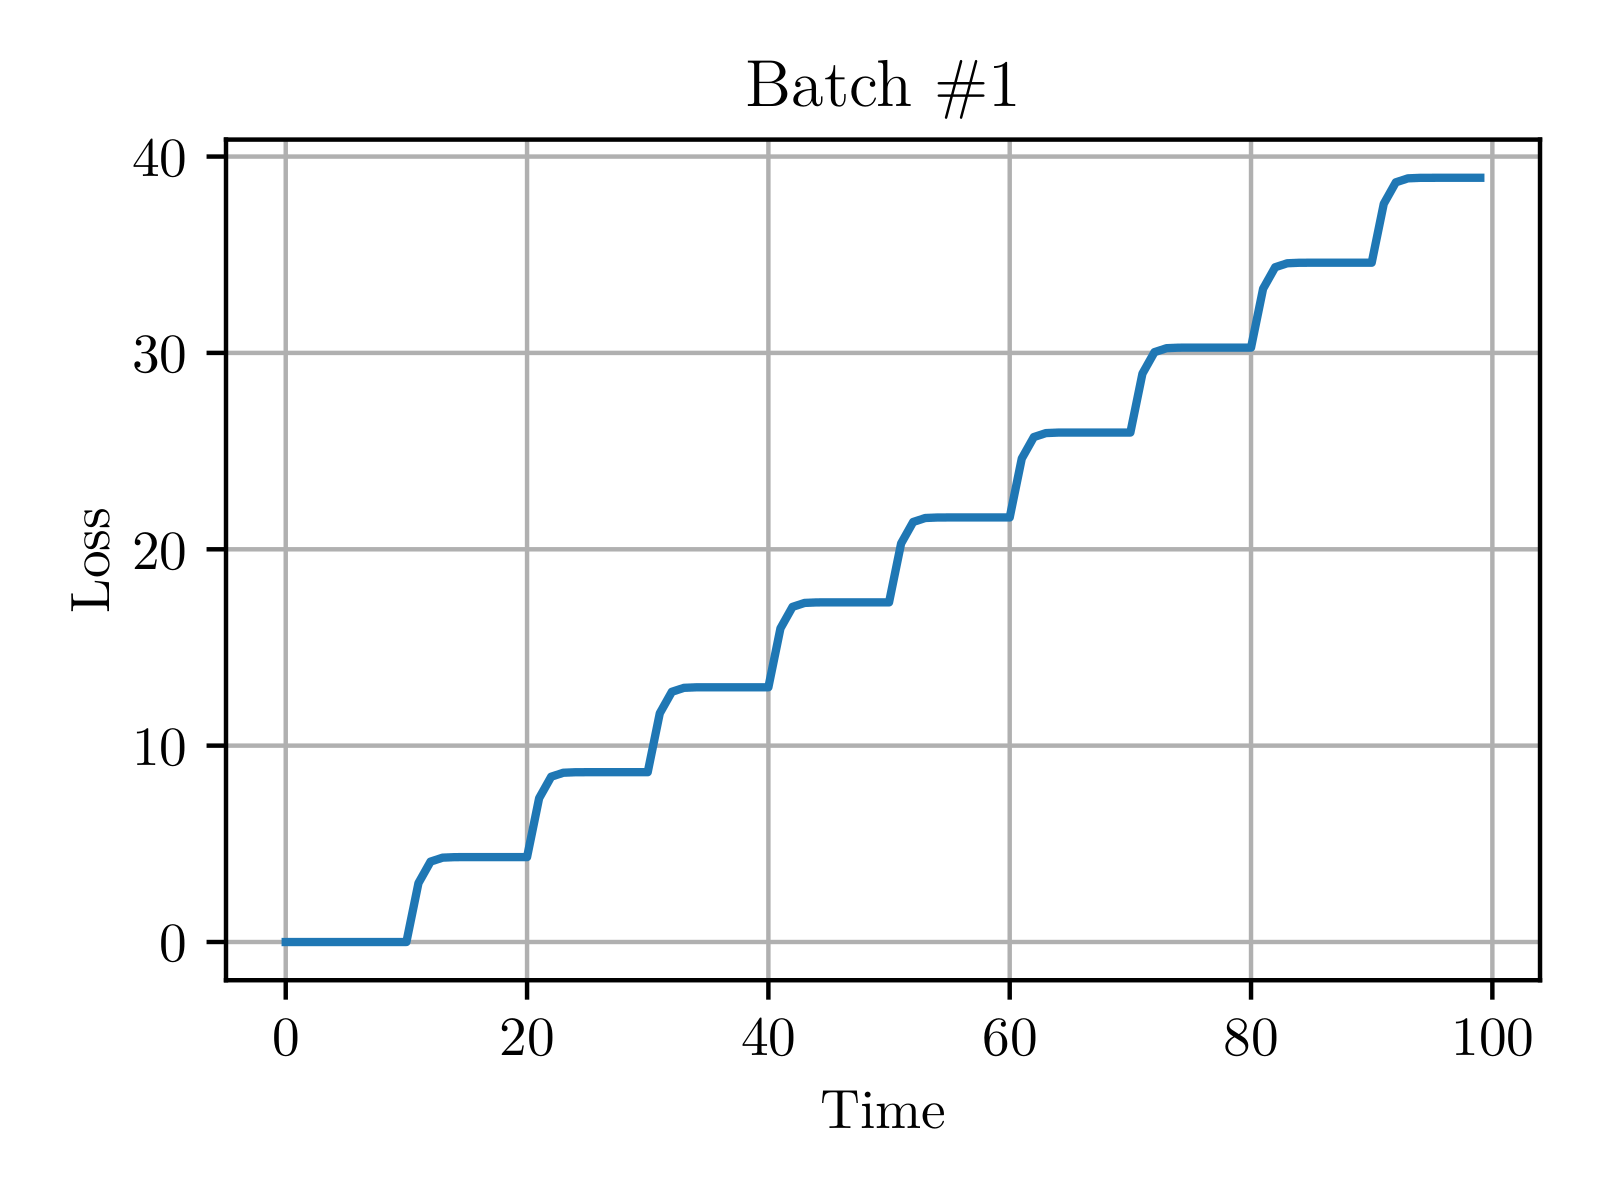
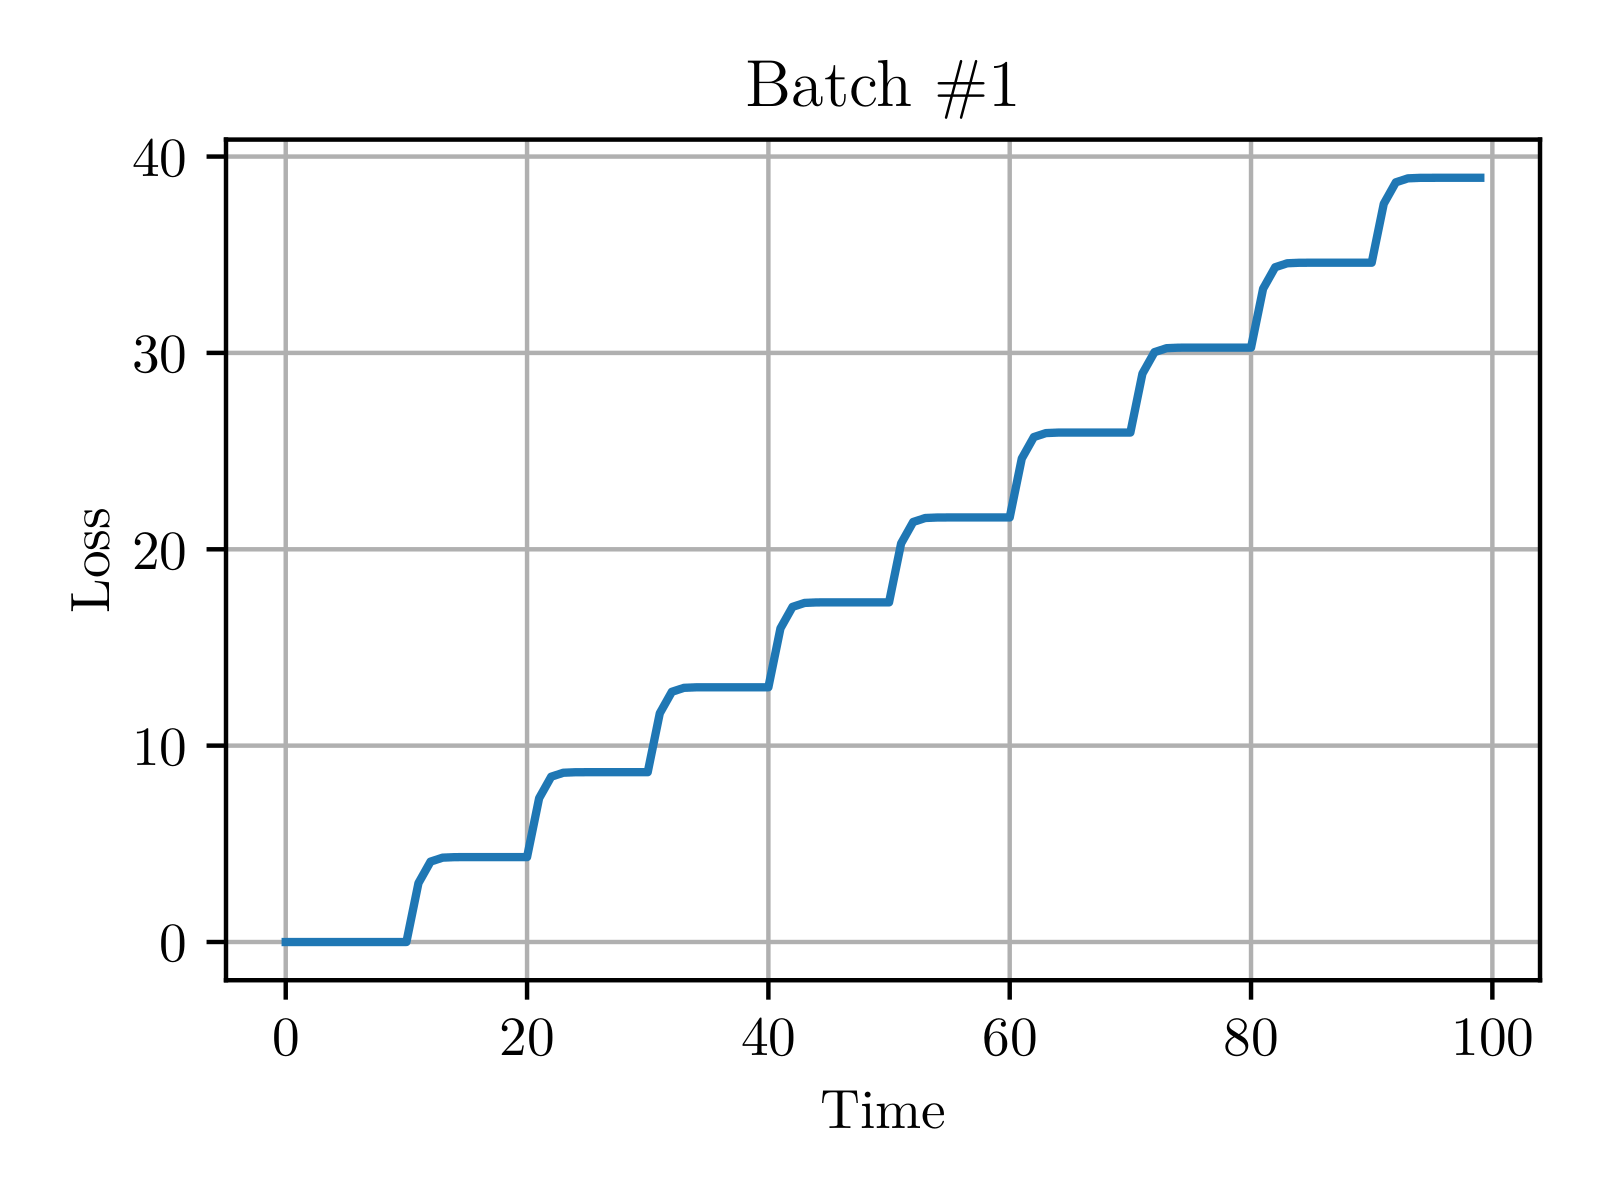
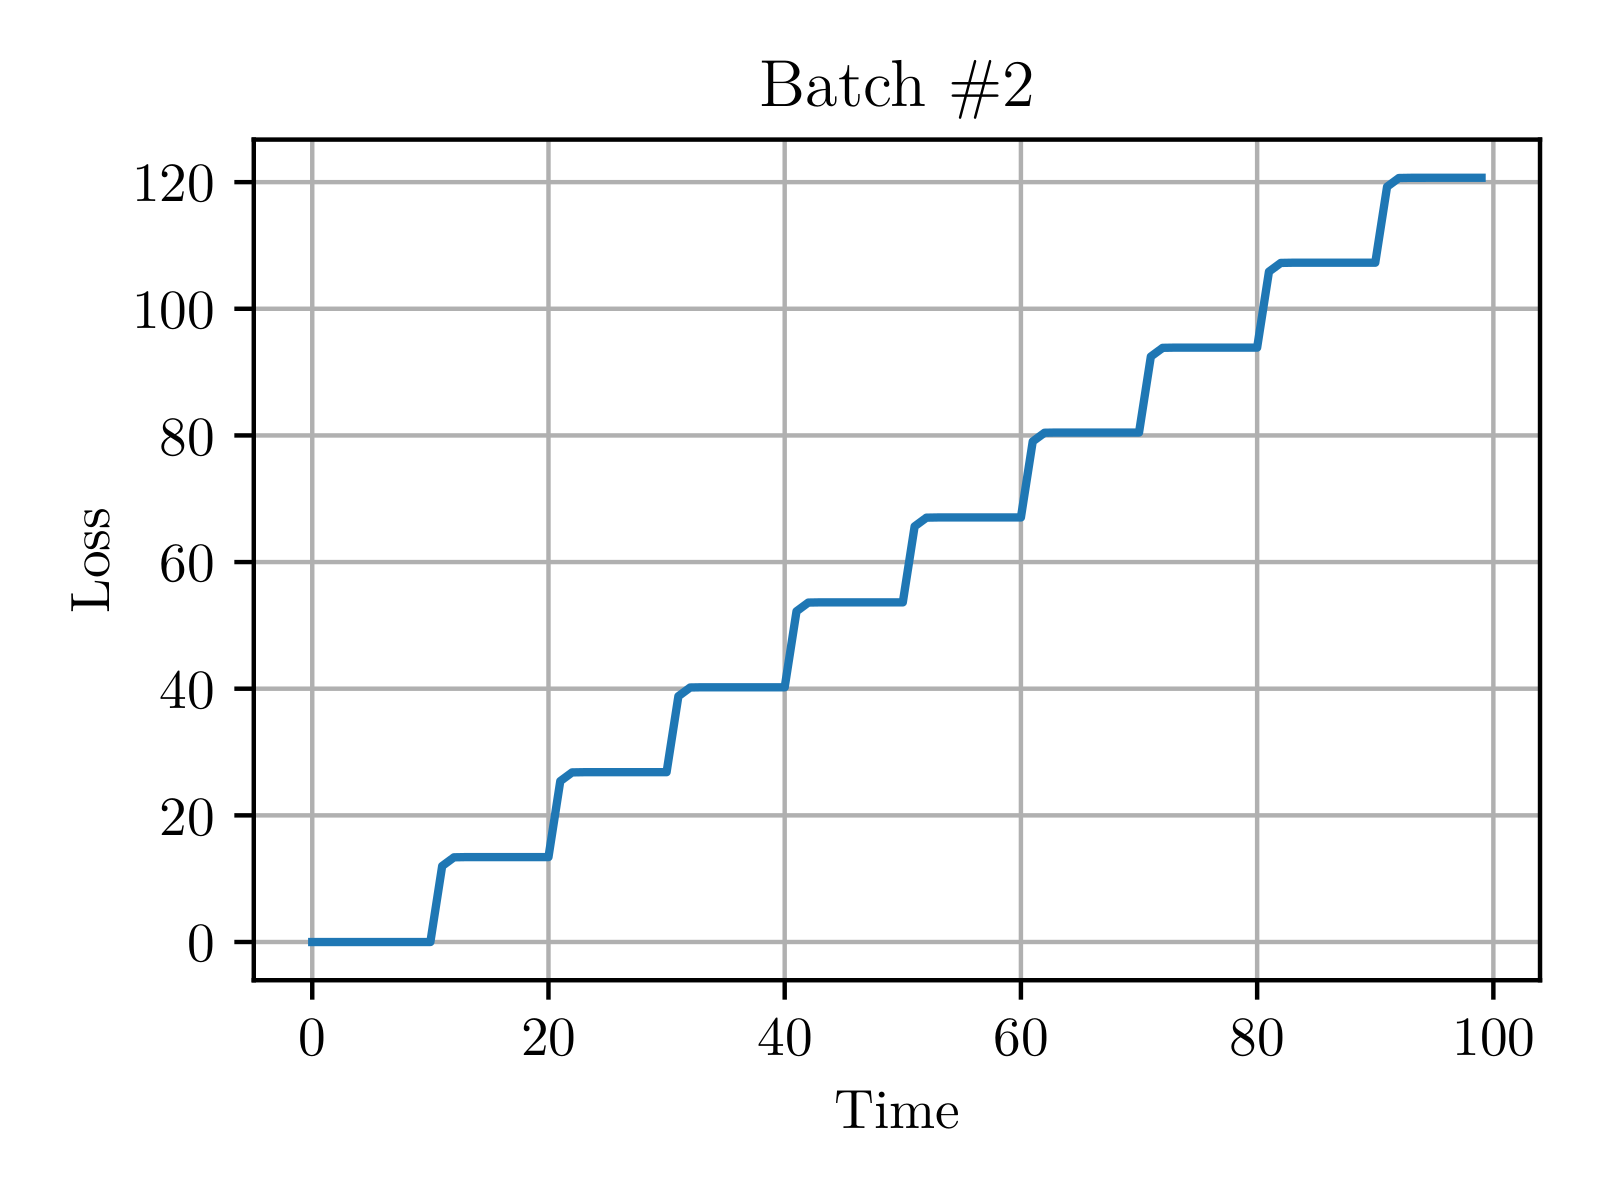
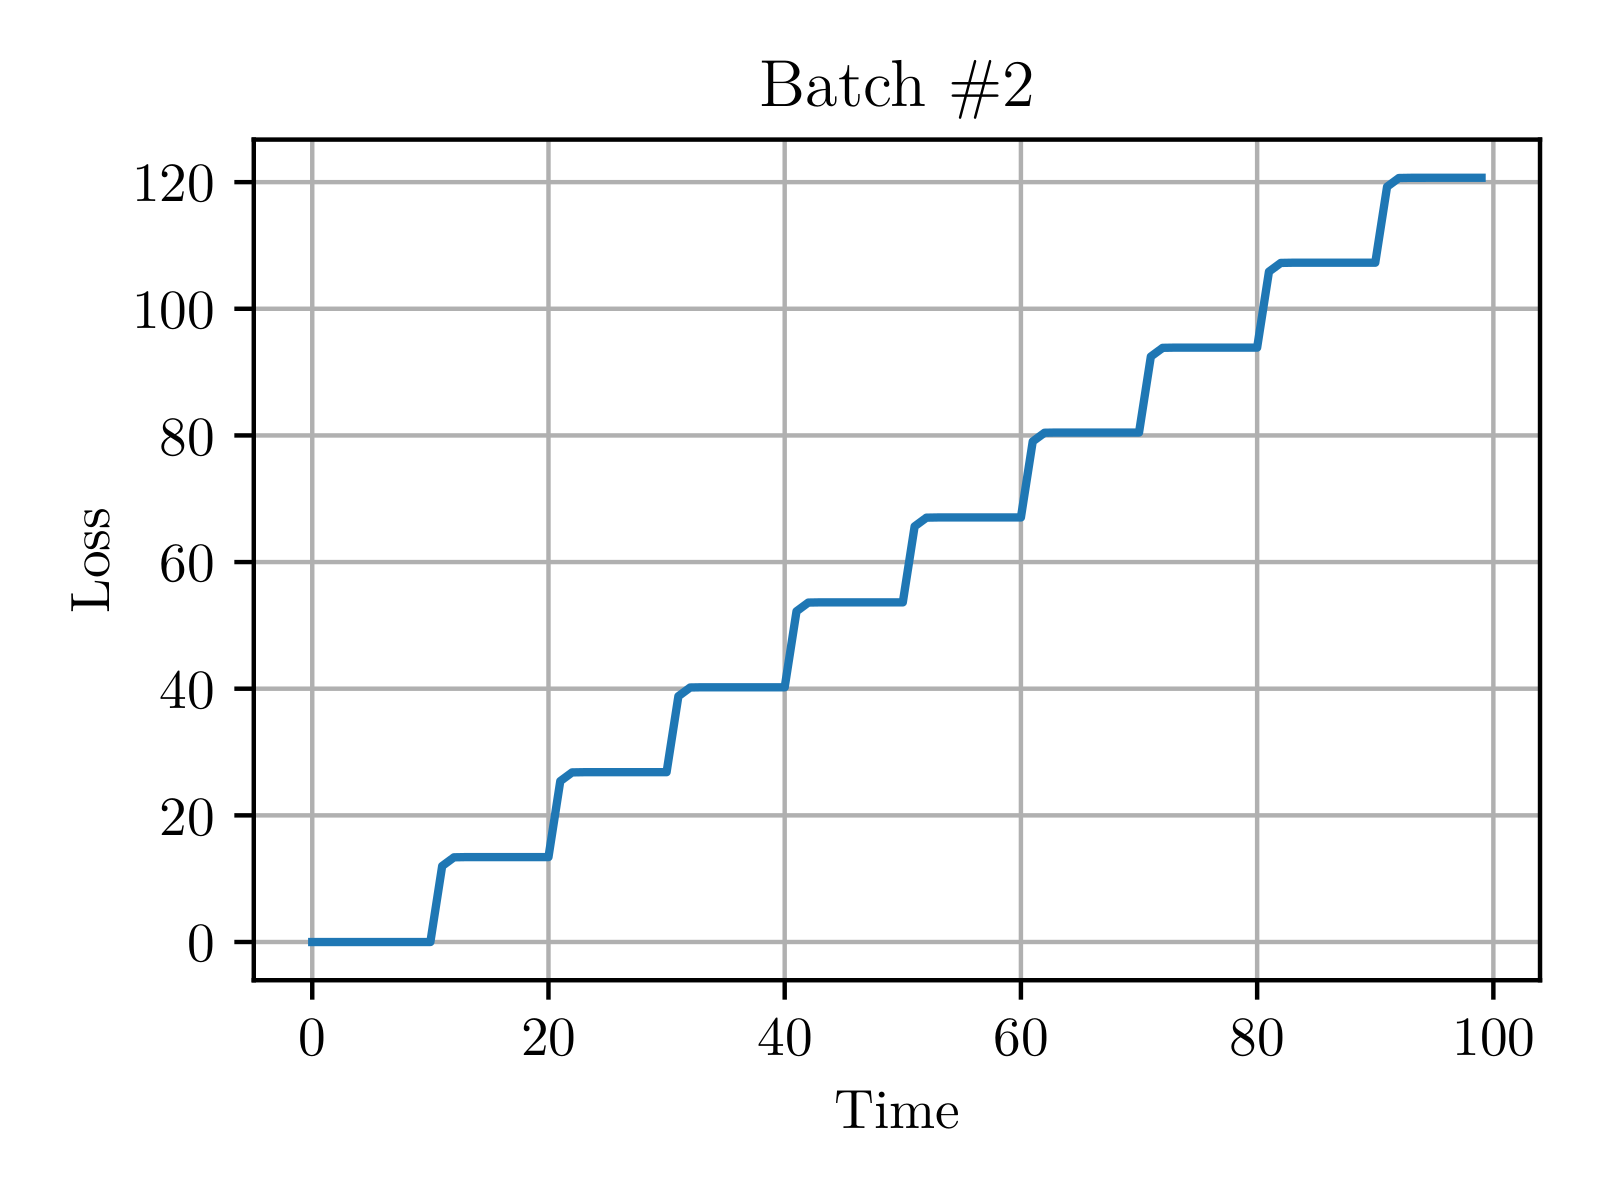
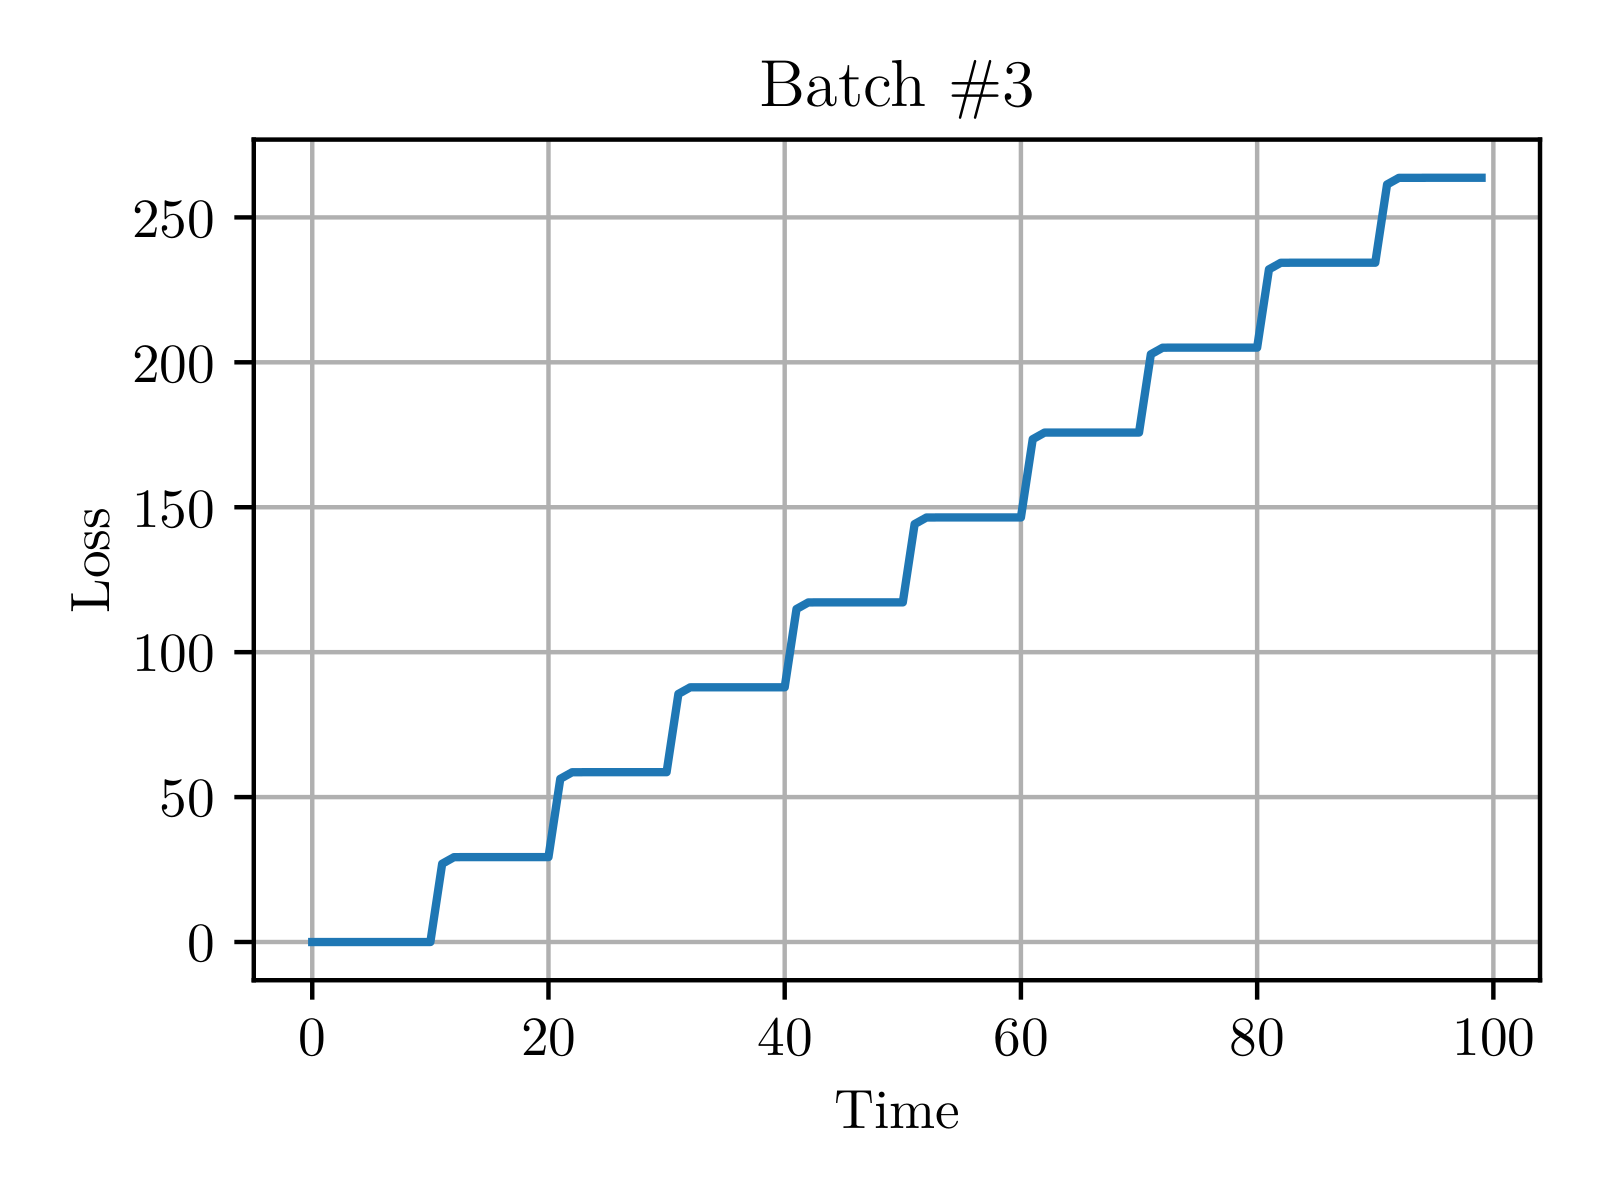
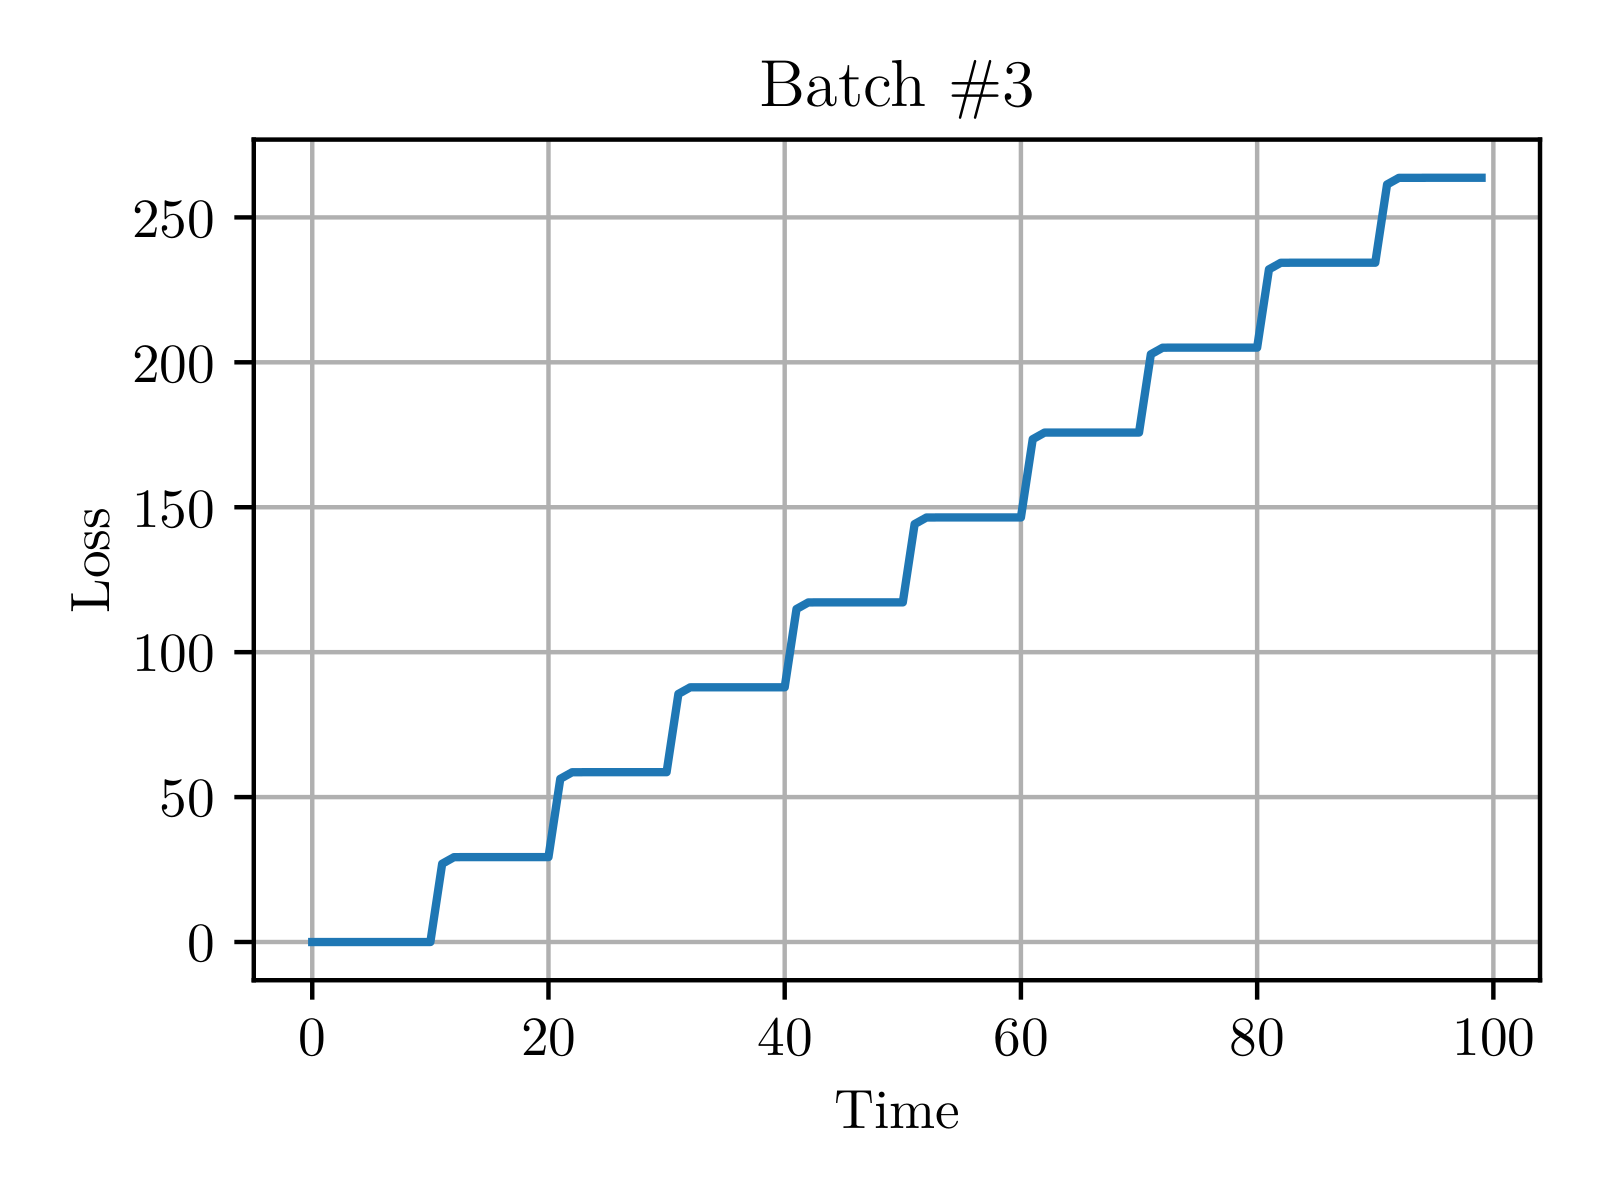
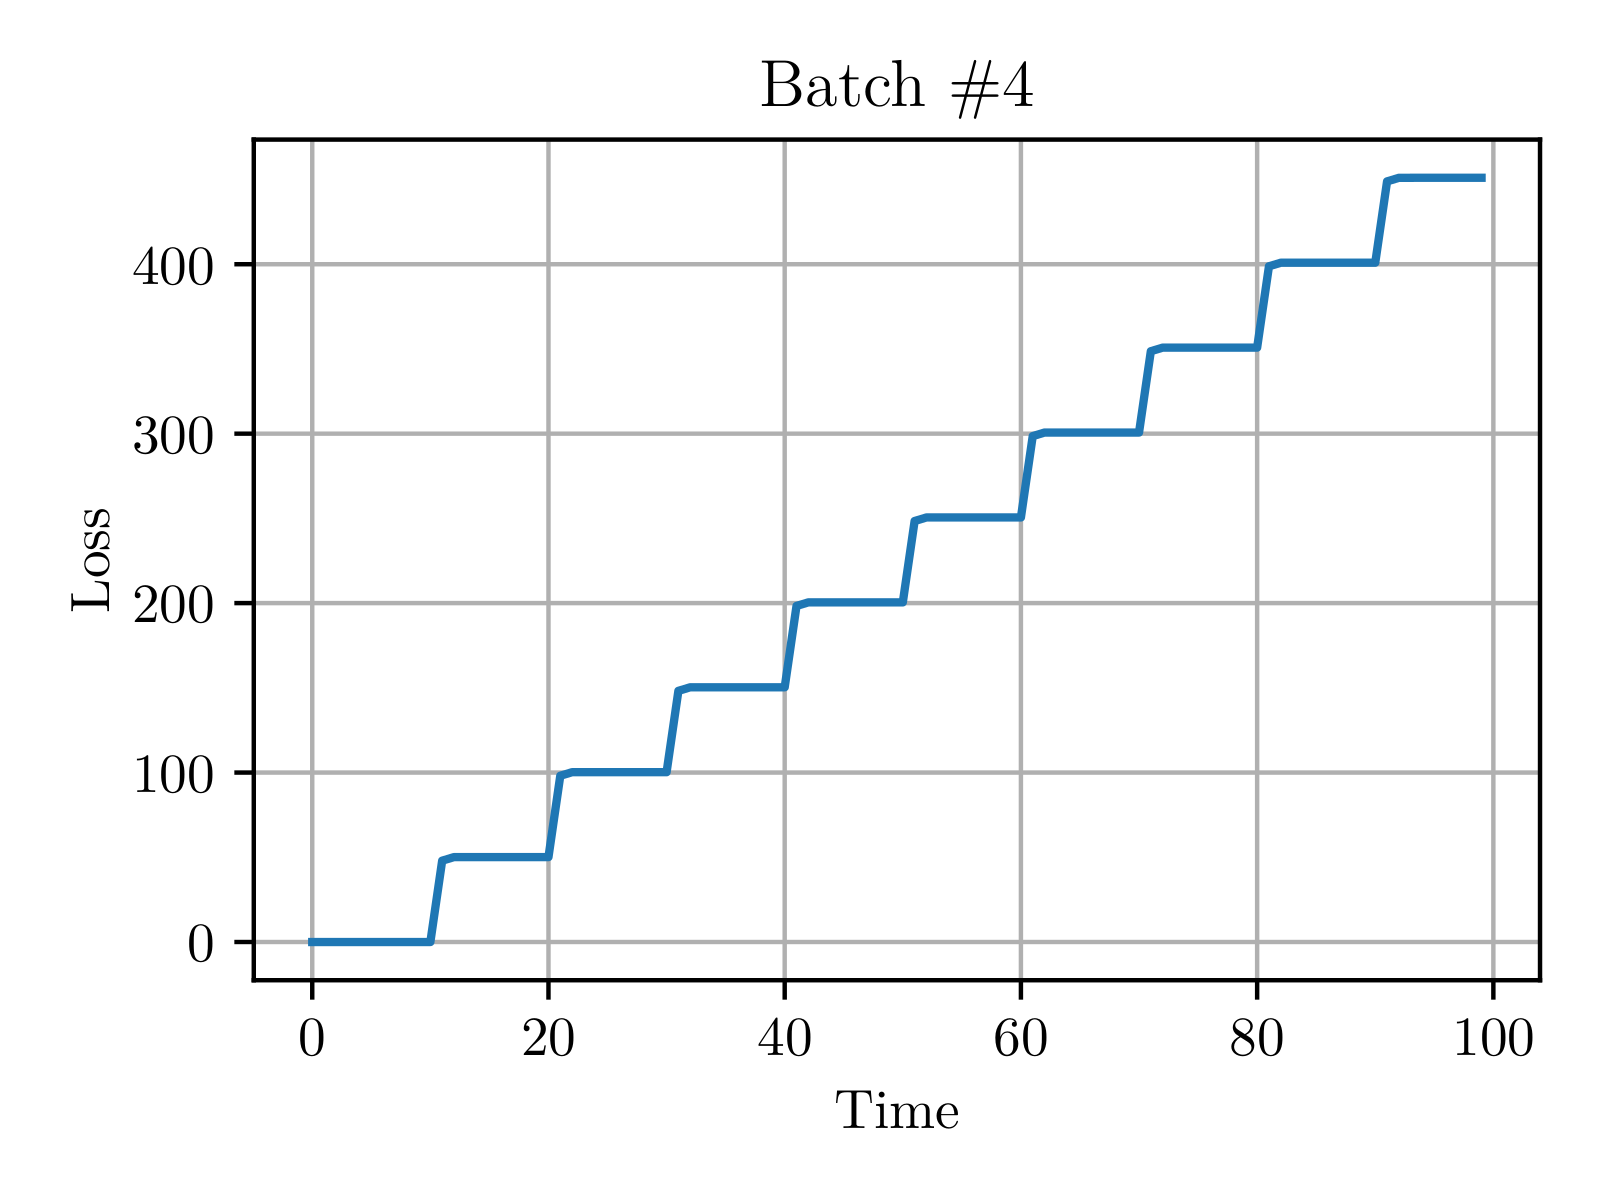
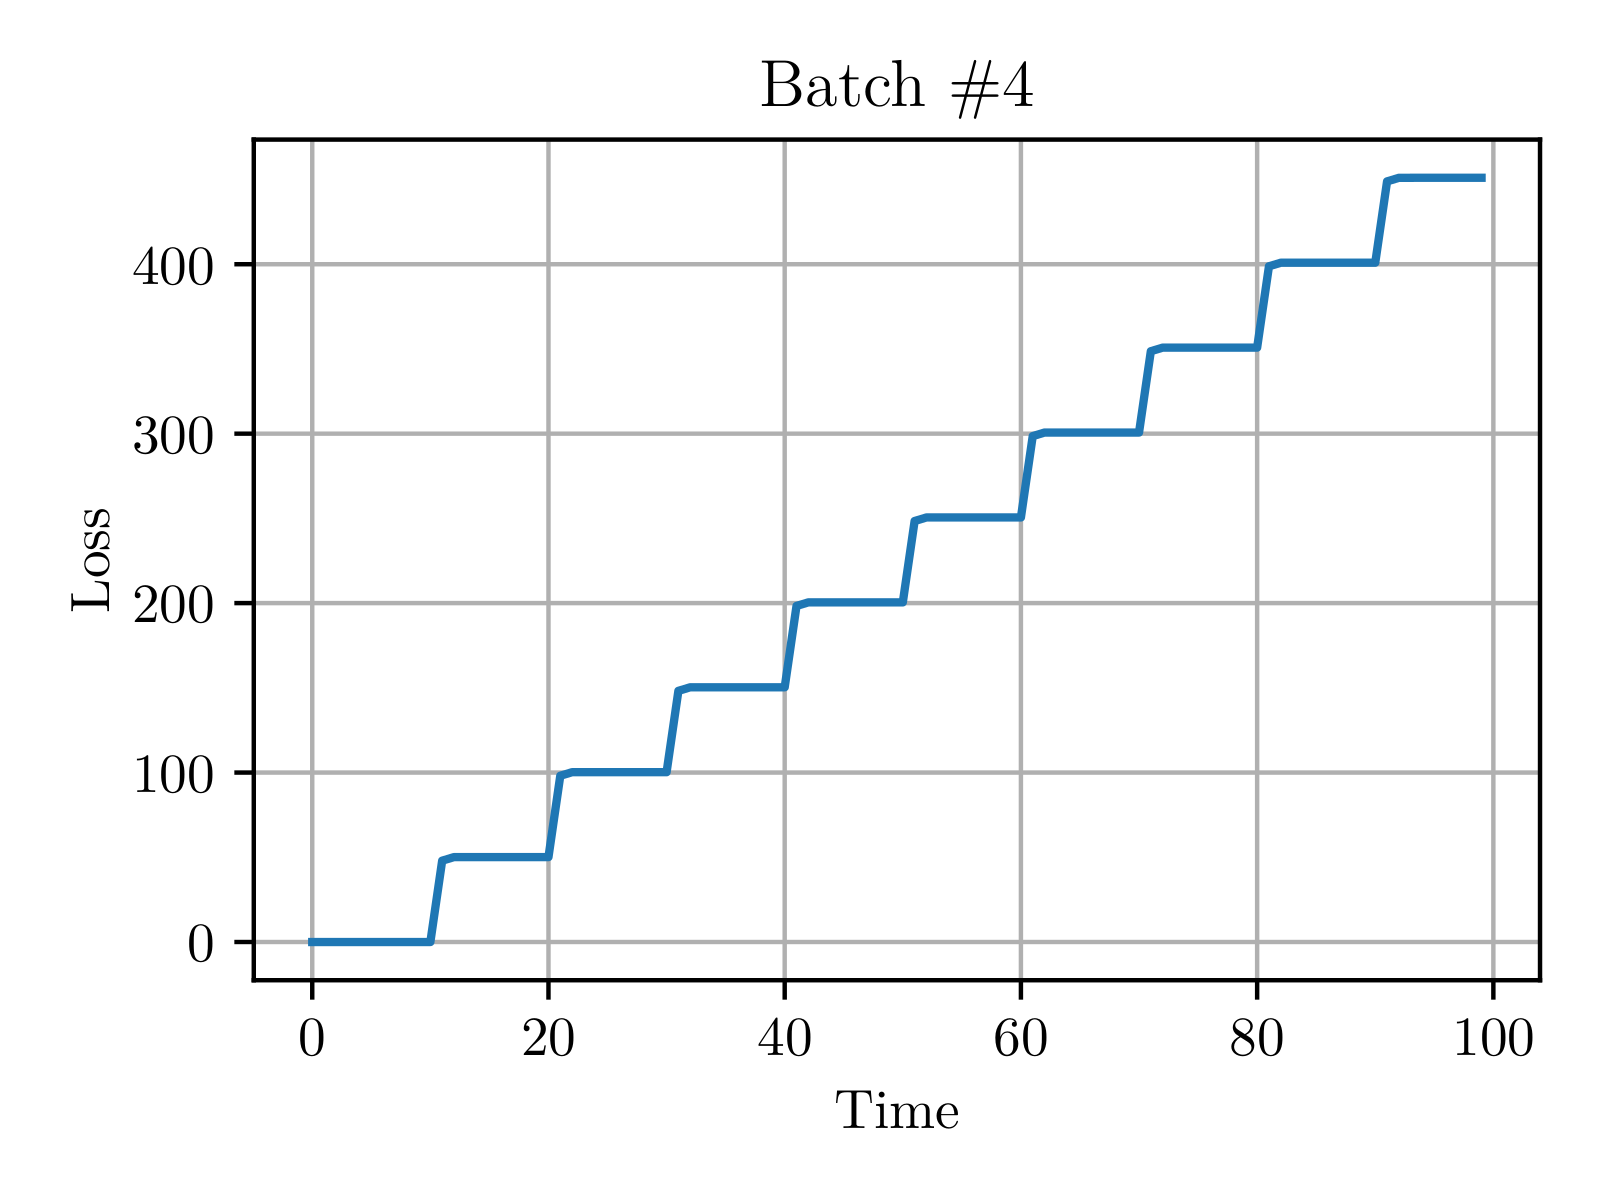

In [18]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses[:, :100], 0, 'loss_b1'),
    plot(losses[:, :100], 1, 'loss_b2'),
    plot(losses[:, :100], 2, 'loss_b3'),
    plot(losses[:, :100], 3, 'loss_b4'),
], n_columns=4)